# Main Model for Handwritten Text Synthesis GAN

This model will consist of 4 major networks, following the general architecture of an GAN.

1. Encoder: Produces an embedding that will be concatenated with the noise vector.
2. Generator: Taking noise vector as input and the text embedding to produce an 128x2048 image.
3. Discriminator: Trained alternating with generator input and ground-truth input, binary classification real or fake.
4. Recognizer: Taking image as input, produce a vector representation of the text.

## Import the required libraries:

In [1]:
import csv
import datetime
import os
import random
import re
import requests

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch_fidelity
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from torch.nn.utils.spectral_norm import spectral_norm
from torch.utils.data import DataLoader, Dataset, RandomSampler, Subset, random_split
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import Grayscale, Resize, ToTensor, ToPILImage
from torchvision.transforms.functional import InterpolationMode
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

/home/kevin/miniconda3/envs/aps360/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

### Helper Functions (Run once only to format data)

In [2]:
SCALE_HEIGHT = 32
SCALE_WIDTH = SCALE_HEIGHT*16

def preprocess_lines(data_root):
    """
    Creates a new `.txt` file `lines_improved.txt` that will be used
    for querying. This new `.txt` file contains all info necessary
    for the functionality of this project.
    """

    original_path = os.path.join(data_root, "lines.txt")
    improved_path = os.path.join(data_root, "lines_improved.txt")
    fi = open(improved_path, "w")

    # Some variables for tracking
    num_samples = 0
    valid_samples = 0
    
    # Loop through "lines.txt"
    with open(original_path, "r") as fo:
        headers = ["image_id", "image_path", "image_pt_path", "graylevel", "original_height", "original_width", "transcription", "transcription_len"]

        # First write the headers at the top of the file
        fi.writelines("\t".join(headers) + "\n")

        # Skip the intro stuff
        for line in fo.readlines():
            if line.startswith("#"):
                continue

            # Valid lines, not the intro_text
            line_items = line.strip().split(" ")  # `strip()` to remove newlines

            # The actual items (we extract the important ones)
            image_id = line_items[0]
            status = line_items[1]
            graylevel = int(line_items[2])
            transcription = " ".join(line_items[8:])  # Some data has whitespace, we join string till the end

            # Skip error images
            if status == "err":
                continue
        
            # Alphanumeric + common punctuation regex
            # Returns None if no match
            # 26 + 26 + 10 + 9 + 1 = 72
            # Spaces might be included as well
            # Punctuation include , ! ? ' " , : ; -
            if re.fullmatch("[a-zA-Z0-9.!?'\",:;| -]*", transcription) is None:
                continue

            # Now we have valid transcription
            num_samples += 1

            # We get the `.png` image path
            inp = image_id.split("-")  # `inp` stands for image name parts
            image_path_head = os.path.join(data_root, "lines", inp[0], f"{inp[0]}-{inp[1]}")
            image_path_tail = f"{image_id}.png"
            image_path = os.path.join(image_path_head, image_path_tail)
            
            # Read image, gets its dimensions, perform processing operations, and other stuff
            tmp_image = cv.imread(os.path.join(image_path_head, image_path_tail), cv.IMREAD_GRAYSCALE)  # Removes the channel dimension
            height, width = tmp_image.shape

            # Scaling calculations
            # If width * scale >= desired length (>= to be safe)
            # Condition here to speed up overall processing time
            if width * (SCALE_HEIGHT/height) >= SCALE_WIDTH:
                continue

            resized_tensor = process_image(tmp_image, graylevel)
            image_pt_path = os.path.join(image_path_head, f"{image_id}.pt")
            torch.save(resized_tensor, image_pt_path)

            # A fully valid image
            # Separate by underscores because `transcription` has spaces so we can't split by spaces
            fi.writelines(f"{image_id}\t{image_path}\t{image_pt_path}\t{graylevel}\t{height}\t{width}\t{transcription}\t{len(transcription)}\n")
            valid_samples += 1
        
        fi.close()
    
    print("# samples:", num_samples)
    print("Valid samples:", valid_samples)


def process_image(cv_image, graylevel):
    """
    Takes in a grayscale image that OpenCV read of shape (H, W) of type uint8
    Returns a PyTorch tensor of shape (1, 32, W'), where W' is the scaled width
    This tensor is padded and effectively thresholded
    """

    # Scaling factor
    height, width = cv_image.shape
    scale = SCALE_HEIGHT/height
    scaled_width = int(width*scale)

    # Trick here is to apply threshold before resize and padding
    # This allows OpenCV resizing to create a cleaner output image
    # 2nd return value is the thresholded image
    output = cv.threshold(cv_image, graylevel, 255, cv.THRESH_BINARY)[1]

    # INTER_AREA recommended for sizing down
    output = cv.resize(output, (scaled_width, SCALE_HEIGHT), interpolation=cv.INTER_AREA)

    # Turn it back to a tensor and map to [0, 1]
    output = torch.from_numpy(output).unsqueeze(0).type(torch.float32)
    output = (output-output.min()) / (output.max()-output.min())
    
    # Add padding
    _, _, resized_height = output.shape
    padding_to_add = SCALE_WIDTH - resized_height
    output = F.pad(output, (0, padding_to_add), value=1.0)

    return output

# Uncomment this if your data isn't processed yet
# preprocess_lines("./data/")

### Important Dict (Run everytime before training)

In [3]:
# Sorted by ascii code
valid = [
    ' ', '!', '"', "'", ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
    ':', ';', '?', 
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
# Enumerate from 1 to save space for padding
# Reserve 0 for CTC blank
char_to_int = {v: i+1 for i, v in enumerate(valid, 1)}
int_to_char = {i+1: v for i, v in enumerate(valid, 1)}

In [4]:
class LineDataset(Dataset):
    def __init__(self, lines_improved_dir, ty=None):
        """
        params:
            lines_improved_dir: path to the `lines_improved.txt` file
            ty: type of the dataset "txt", "img" for text dataset or image dataset.
        """
        
        # Dataframe containing the stuff in `lines_improved.txt`
        self.lines_df = pd.read_csv(lines_improved_dir, sep="\t", quoting=csv.QUOTE_NONE)

        # Class properties
        self.ty = ty  # Type of dataset (lines, images, or both)
        self.max_transcription_len = max(self.lines_df["transcription_len"])

        # Temp variables...
        length = self.lines_df.shape[0]
        line_datas = self.lines_df.iloc
        ret_texts = [line_datas[i]["transcription"].replace('|', ' ') for i in range(length)]
        ret_ctois = [torch.tensor([char_to_int[char] for char in ret_texts[i]]) for i in range(length)]

        # ...for the important data
        if self.ty in ("txt", None):  # Added this condition to speed thigns up if only text
            self.ret_ctoi_paddeds = [F.pad(ret_ctois[i], pad=(0, self.max_transcription_len-len(ret_ctois[i]))) for i in range(length)]
        if self.ty in ("img", None):
            self.ret_images = [torch.load(line_datas[i]["image_pt_path"]) for i in range(length)]

    def __len__(self):
        return len(self.lines_df)
    
    def __getitem__(self, index):
        # Different type of individual loaders
        if self.ty == "txt":
            return self.ret_ctoi_paddeds[index]
        elif self.ty == "img":
            return self.ret_images[index]
        else:
            return self.ret_images[index], self.ret_ctoi_paddeds[index]

In [5]:
line_transcription_dataset = LineDataset("./data/lines_improved.txt", ty="txt")
line_image_dataset = LineDataset("./data/lines_improved.txt", ty="img")
line_dataset = LineDataset("./data/lines_improved.txt")

# Don't change this, we want to maintain consistent split
torch.manual_seed(12345678)  # DO NOT REMOVE THIS LINE
line_transcription_dataset_train, line_transcription_dataset_val = random_split(line_transcription_dataset, [0.8, 0.2])
line_image_dataset_train, line_image_dataset_val = random_split(line_image_dataset, [0.8, 0.2])
line_dataset_train, line_dataset_val = random_split(line_dataset, [0.8, 0.2])

# To train on a small dataset
line_transcription_dataset_train = Subset(line_transcription_dataset_train, range(20))
line_transcription_dataset_val = Subset(line_transcription_dataset_val, range(10))

line_image_dataset_train = Subset(line_image_dataset_train, range(20))
line_image_dataset_val = Subset(line_image_dataset_val, range(10))

# line_transcription_dataset_train, line_transcription_dataset_val, _ = random_split(line_transcription_dataset, [0.005, 0.005, 0.99])
# line_image_dataset_train, line_image_dataset_val, _ = random_split(line_image_dataset, [0.005, 0.005, 0.99])
# line_dataset_train, line_dataset_val = random_split(line_dataset, [0.0025, 0.9975])

print("lines")
print(len(line_transcription_dataset_train), len(line_transcription_dataset_val))
print("images")
print(len(line_image_dataset_train), len(line_image_dataset_val))
print("both")
print(len(line_dataset_train), len(line_dataset_val))


lines
20 10
images
20 10
both
5708 1427


torch.Size([1, 32, 512])
torch.Size([32, 512])
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.0000, 0.6196, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.4549, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])


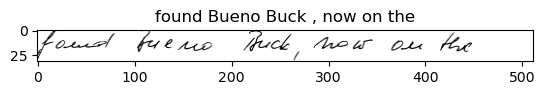

In [6]:
image, label = line_dataset_train[283]
print(image.shape)
plt.title("".join([int_to_char[int(val)] for val in label[label.nonzero()]]))
print(image.squeeze(0).shape)
plt.imshow(image.squeeze(0), cmap='gray')
label, "".join([int_to_char[int(val)] for val in label[label.nonzero()]])
# line_dataset.lines_df.iloc[798]
print(image)

In [7]:
# # plt.imshow(line_dataset.lines_df["image_path"])
# image = read_image(line_dataset.lines_df["image_path"].iloc[283]).squeeze(0)
# plt.imshow(image, cmap="gray")

In [8]:
# plt.imshow(line_image_dataset[1000], cmap="gray")

In [9]:
# for i in DataLoader(line_image_dataset, batch_size=64, shuffle=True):
#     print(i.shape)
#     ...

Define Key Functions

In [29]:
"""Dataloading Functions"""
"""Datasaving Functions"""

"""Plotting Functions"""
"""Evaluation Functions"""
def calculate_gan_loss_and_accuracies(generator, encoder, discriminator, recognizer, 
                                  real_image_loader, input_text_loader, 
                                  batch_size=64, adversarial_loss_function=nn.BCELoss(), recognizer_loss_function=nn.CTCLoss(),
                                  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Calculates the loss for the GAN
    
    Params:
        generator: The generator model
        encoder: The encoder model
        discriminator: The discriminator model
        recognizer: The recognizer model
        real_image_loader: The dataloader for real images
        input_text_loader: The dataloader for input text
        batch_size: The batch size to use
        adversarial_loss_function: The adversarial loss function to use
        recognizer_loss_function: The recognizer loss function to use

    Returns:
        generator_and_encoder_loss: The loss for the generator and encoder
        discriminator_loss: The loss for the discriminator
    """
    fid = FrechetInceptionDistance(feature=2048, reset_real_features=False)
    for real_image_batch in real_image_loader:
        fid.update((real_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=True)

    generator_and_encoder_loss = 0
    discriminator_loss = 0
    discriminator_accuracy = 0
    with torch.no_grad():
        for i, (real_image_batch, input_text_batch) in enumerate(zip(real_image_loader, input_text_loader)):
            real_image_batch = real_image_batch.to(device)
            input_text_batch = input_text_batch.to(device)

            # generate noise of N x noise_dim
            noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)

            # Use encoder and generator to generate fake images
            text_embedding = encoder(input_text_batch)
            fake_image_batch = generator(noise, text_embedding)

            # train discriminator
            discriminator_output_for_real_images = discriminator(real_image_batch)
            discriminator_output_for_fake_images = discriminator(fake_image_batch)
            label_for_real_images = torch.ones_like(discriminator_output_for_real_images).to(device)
            label_for_fake_images = torch.zeros_like(discriminator_output_for_fake_images).to(device)
            real_images_loss = adversarial_loss_function(discriminator_output_for_real_images, label_for_real_images)
            fake_images_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_fake_images)
            discriminator_loss = (real_images_loss + fake_images_loss) / 2
            discriminator_loss += discriminator_loss.item()
            discriminator_accuracy += (torch.sum(discriminator_output_for_real_images >= 0.5).item() + torch.sum(discriminator_output_for_fake_images < 0.5).item()) / (2 * batch_size)

            # train generator
            
            adversarial_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_real_images)
            recognizer_outputs = recognizer(fake_image_batch)
            input_lengths = torch.full(size=(batch_size,), fill_value=2*82+1)
            target_lengths = torch.full(size=(batch_size,), fill_value=82)
            recognizer_loss = recognizer_loss_function(
                recognizer_outputs.log_softmax(2),
                input_text_batch,
                input_lengths,
                target_lengths
            )
            
            # balance the losses from different sources, according to https://arxiv.org/pdf/1903.00277.pdf
            adversarial_loss_mean, adversarial_loss_std = torch.mean(adversarial_loss), torch.std(adversarial_loss)
            # recognizer_loss_mean, recognizer_loss_std = torch.mean(recognizer_loss), torch.std(recognizer_loss)
            # recognizer_loss = loss_balancing_alpha * (adversarial_loss_std / recognizer_loss_std) * (recognizer_loss - recognizer_loss_mean) + adversarial_loss_mean
            
            print("ADLOSS", adversarial_loss, "CTC", recognizer_loss)
            generator_loss = adversarial_loss + recognizer_loss
            generator_and_encoder_loss += generator_loss.item()

            # calculate fid
            fid.update((real_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=True)
            fid.update((fake_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=False)

    generator_and_encoder_error = fid.compute().item()
    fid.reset()
    discriminator_accuracy /= len(real_image_loader)
    generator_and_encoder_loss /= len(real_image_loader)
    discriminator_loss /= len(input_text_loader)

    return generator_and_encoder_loss, discriminator_loss, generator_and_encoder_error, discriminator_accuracy

"""Training Functions"""
def train_recognizer(recognizer, train_line_loader, val_line_loader, batch_size=64, learning_rate=2e-4, betas=(0, 0.999), num_epochs=30):
    # only train on real images
    # also save model, plot graphs, save graphs
    pass

def train_gan(generator, encoder, discriminator, recognizer, 
              train_real_image_dataset, val_real_image_dataset, 
              train_input_text_dataset, val_input_text_dataset, 
              batch_size=64, encoder_lr=1e-5, generator_lr=1e-5, discriminator_lr=1e-5, recognizer_lr=1e-5,
              betas=(0, 0.999), num_epochs=30, loss_balancing_alpha=1,
              num_generator_updates_per_discriminator_update=1):
    # Note, the generator and discriminator should be spectrally normalized before training
    # TODO: load dataloader with batch size batch_size

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cpu')
    print(device)
    generator = generator.to(device)
    encoder = encoder.to(device)
    discriminator = discriminator.to(device)
    recognizer = recognizer.to(device)
    
    train_real_image_loader = DataLoader(train_real_image_dataset, batch_size=batch_size, shuffle=True)
    val_real_image_loader = DataLoader(val_real_image_dataset, batch_size=batch_size, shuffle=True)
    train_input_text_loader = DataLoader(train_input_text_dataset, batch_size=batch_size, shuffle=True)
    val_input_text_loader = DataLoader(val_input_text_dataset, batch_size=batch_size, shuffle=True)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=encoder_lr, betas=betas)
    generator_optimizer = optim.Adam(generator.parameters(), lr=generator_lr, betas=betas)
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=betas)
    recognizer_optimizer = optim.Adam(recognizer.parameters(), lr=recognizer_lr, betas=betas)
    
    adversarial_loss_function = nn.BCELoss()  # discriminator already has sigmoid
    recognizer_loss_function = nn.CTCLoss()
    saving_filenames = {
        "encoder": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lrE{encoder_lr}_lrG{generator_lr}_lrD{discriminator_lr}_lrR{recognizer_lr}_betas{betas}_encoder"),
        "generator": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lrE{encoder_lr}_lrG{generator_lr}_lrD{discriminator_lr}_lrR{recognizer_lr}_betas{betas}_generator"),
        "discriminator": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lrE{encoder_lr}_lrG{generator_lr}_lrD{discriminator_lr}_lrR{recognizer_lr}_betas{betas}_discriminator"), 
        "losses": os.path.join("main_model", "model_training_information", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lrE{encoder_lr}_lrG{generator_lr}_lrD{discriminator_lr}_lrR{recognizer_lr}_betas{betas}_losses"),
        "accuracies": os.path.join("main_model", "model_training_information", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lrE{encoder_lr}_lrG{generator_lr}_lrD{discriminator_lr}_lrR{recognizer_lr}_accuracies")
        }

    best_generator_and_encoder_val_loss = float('inf')
    best_discriminator_val_loss = float('inf')
    best_generator_and_encoder_val_error = 0
    best_discriminator_val_accuracy = 0
    saved_generator_and_encoder_models_epochs = []
    saved_discriminator_models_epochs = []

    generator_and_encoder_train_losses = []
    discriminator_train_losses = []
    generator_and_encoder_train_accuracies = []
    discriminator_train_accuracies = []
    generator_and_encoder_val_losses = []
    discriminator_val_losses = []
    generator_and_encoder_val_accuracies = []
    discriminator_val_accuracies = []

    # FID: https://torchmetrics.readthedocs.io/en/stable/image/frechet_inception_distance.html
    fid = FrechetInceptionDistance(feature=2048, reset_real_features=False)
    image_count = 0
    for real_image_batch in train_real_image_loader:
        image_count += len(real_image_batch)
        print("fid load image_count", image_count)
        fid.update((real_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=True)

    for epoch in range(num_epochs):
        display_images = []

        generator_and_encoder_train_loss = 0
        discriminator_train_loss = 0
        discriminator_train_accuracy = 0

        for i, (real_image_batch, input_text_batch) in enumerate(zip(train_real_image_loader, train_input_text_loader)):
            print("epoch", epoch, "batch", i)
            print("real_image_batch.shape", real_image_batch.shape)
            print("input_text_batch.shape", input_text_batch.shape)

            real_image_batch = real_image_batch.to(device)
            input_text_batch = input_text_batch.to(device)

            # generate noise of N x noise_dim
            noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)

            # Use encoder and generator to generate fake images
            text_embedding = encoder(input_text_batch)
            print(noise.shape, text_embedding.shape)
            fake_image_batch = generator(noise, text_embedding)

            # display random image from the batch
            plt.imshow(fake_image_batch.cpu().detach().numpy()[0].squeeze(0), cmap='gray')
            plt.show()

            # Only train discriminator every num_generator_updates_per_discriminator_update iterations
            if i % num_generator_updates_per_discriminator_update == 0:
                # train discriminator
                discriminator_optimizer.zero_grad()
                discriminator_output_for_real_images = discriminator(real_image_batch)
                discriminator_output_for_fake_images = discriminator(fake_image_batch.detach())  # added detatch to prevent gradients from flowing back to generator
                label_for_real_images = torch.ones_like(discriminator_output_for_real_images).to(device)*0.99  # To prevent discriminator from getting too confident
                label_for_fake_images = torch.zeros_like(discriminator_output_for_fake_images).to(device)+0.01  # To prevent discriminator from getting too confident
                real_images_loss = adversarial_loss_function(discriminator_output_for_real_images, label_for_real_images)
                fake_images_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_fake_images)
                discriminator_loss = real_images_loss + fake_images_loss
                discriminator_loss.backward()  # retain_graph=True because we will use the same discriminator for the generator
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=0.5)
                
                discriminator_optimizer.step()
                discriminator_train_loss += discriminator_loss.item()
                discriminator_train_accuracy += (torch.sum(discriminator_output_for_real_images > 0.5) + torch.sum(discriminator_output_for_fake_images < 0.5)) / (2 * batch_size)
                print("DISC_OUTPUT_FOR_FAKE", discriminator_output_for_fake_images)
                print("D_OUTPUT_FOR_REAL", discriminator_output_for_real_images)

            # train generator
            generator_optimizer.zero_grad()
            encoder_optimizer.zero_grad()
            # # generate noise of N x noise_dim
            # noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)
            # # Use encoder and generator to generate fake images
            # text_embedding = encoder(input_text_batch)
            # fake_image_batch = generator(noise, text_embedding)
            # # display random image from the batch
            # plt.imshow(fake_image_batch.cpu().detach().numpy()[0].squeeze(0), cmap='gray')
            # plt.show()
            discriminator_output_for_fake_images = discriminator(fake_image_batch)
            adversarial_loss = adversarial_loss_function(discriminator_output_for_fake_images, torch.ones_like(discriminator_output_for_fake_images).to(device)*0.99)  # note that we want the fake images to be classified as real, also the *0.99 is to prevent generator from getting too confident
            print(torch.sum(discriminator_output_for_fake_images > 0.5))
            print(adversarial_loss)
            print(discriminator_output_for_fake_images)
            recognizer_outputs = recognizer(fake_image_batch)
            # Refer to CTC documentation
            input_lengths = torch.full(size=(batch_size,), fill_value=2*82+1)
            target_lengths = torch.full(size=(batch_size,), fill_value=82)
            recognizer_loss = recognizer_loss_function(
                recognizer_outputs.log_softmax(2),
                input_text_batch,
                input_lengths,
                target_lengths
            )
            
            # balance the losses from different sources, according to https://arxiv.org/pdf/1903.00277.pdf
            adversarial_loss_mean, adversarial_loss_std = torch.mean(adversarial_loss), torch.std(adversarial_loss)
            # recognizer_loss_mean, recognizer_loss_std = torch.mean(recognizer_loss), torch.std(recognizer_loss)
            # recognizer_loss = loss_balancing_alpha * (adversarial_loss_std / recognizer_loss_std) * (recognizer_loss - recognizer_loss_mean) + adversarial_loss_mean
            
            generator_loss = adversarial_loss + recognizer_loss
            generator_loss.backward()
            recognizer_optimizer.step()
            generator_optimizer.step()
            encoder_optimizer.step()
            generator_and_encoder_train_loss += generator_loss.item()
            
            # calculate FID
            fid.update((fake_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=False)

            # display_images.append(fake_image_batch[random.randint(0, len(fake_image_batch) - 1)].detach().numpy())

        # plot the collection of display_images, all are greyscale
        # display_images = np.array(display_images)
        # display_images = np.transpose(display_images, (0, 2, 3, 1))
        # display_images = np.squeeze(display_images)
        # plt.figure(figsize=(10, 10))
        # for i in range(25):
        #     plt.subplot(5, 5, i + 1)
        #     plt.imshow(display_images[i], cmap='gray')
        #     plt.axis('off')
        # plt.tight_layout()
        # plt.show()
        # plt.clf()


        # Tally up losses and accuracies
        generator_and_encoder_train_loss /= len(train_real_image_loader)
        discriminator_train_loss /= len(train_real_image_loader)
        generator_and_encoder_train_error = fid.compute().item()
        fid.reset()
        discriminator_train_accuracy /= len(train_real_image_loader)
        generator_and_encoder_train_losses.append(generator_and_encoder_train_loss)
        discriminator_train_losses.append(discriminator_train_loss)
        generator_and_encoder_train_accuracies.append(generator_and_encoder_train_error)
        discriminator_train_accuracies.append(discriminator_train_accuracy.cpu().numpy())

        generator_and_encoder_val_loss, discriminator_val_loss, generator_and_encoder_val_error, discriminator_val_accuracy = calculate_gan_loss_and_accuracies(generator, encoder, discriminator, recognizer, val_real_image_loader, val_input_text_loader, batch_size=batch_size)
        generator_and_encoder_val_losses.append(generator_and_encoder_val_loss)
        discriminator_val_losses.append(discriminator_val_loss.cpu().numpy())
        generator_and_encoder_val_accuracies.append(generator_and_encoder_val_error)
        discriminator_val_accuracies.append(discriminator_val_accuracy)

        print(f"Epoch {epoch}:\n\tGenerator and encoder train loss: {generator_and_encoder_train_loss}\n\tDiscriminator train loss: {discriminator_train_loss}\n\tGenerator and encoder train accuracy: {generator_and_encoder_train_error}\n\tDiscriminator train accuracy: {discriminator_train_accuracy}\n\tGenerator and encoder val loss: {generator_and_encoder_val_loss}\n\tDiscriminator val loss: {discriminator_val_loss}\n\tGenerator and encoder val accuracy: {generator_and_encoder_val_error}\n\tDiscriminator val accuracy: {discriminator_val_accuracy}")

        # Save models, only if they are better than the previous best
        if generator_and_encoder_val_loss < best_generator_and_encoder_val_loss:
            best_generator_and_encoder_val_loss = generator_and_encoder_val_loss
            saved_generator_and_encoder_models_epochs.append(epoch)
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if discriminator_val_loss < best_discriminator_val_loss:
            best_discriminator_val_loss = discriminator_val_loss
            saved_discriminator_models_epochs.append(epoch)
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if generator_and_encoder_val_error < best_generator_and_encoder_val_error:
            best_generator_and_encoder_val_error = generator_and_encoder_val_error
            saved_generator_and_encoder_models_epochs.append(epoch) if epoch not in saved_generator_and_encoder_models_epochs else None
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if discriminator_val_accuracy > best_discriminator_val_accuracy:
            best_discriminator_val_accuracy = discriminator_val_accuracy
            saved_discriminator_models_epochs.append(epoch) if epoch not in saved_discriminator_models_epochs else None
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")

        # plot title
        plt.title("generator and encoder losses")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("loss")
        # plot the epoch vs the loss
        plt.plot(range(epoch+1), generator_and_encoder_train_losses, label="train")
        plt.plot(range(epoch+1), generator_and_encoder_val_losses, label="val")
        # plot the saved models as dots
        plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_losses[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # save the plot
        plt.close()

        # plot title
        plt.title("discriminator losses")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("loss")
        # plot the epoch vs the loss
        plt.plot(range(epoch+1), discriminator_train_losses, label="train")
        plt.plot(range(epoch+1), discriminator_val_losses, label="val")
        # plot the saved models as dots
        plt.scatter(saved_discriminator_models_epochs, [discriminator_val_losses[i] for i in saved_discriminator_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

        # plot title
        plt.title("generator and encoder errors")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("accuracy")
        # plot the epoch vs the accuracy
        plt.plot(range(epoch+1), generator_and_encoder_train_accuracies, label="train")
        plt.plot(range(epoch+1), generator_and_encoder_val_accuracies, label="val")
        # plot the saved models as dots
        plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_accuracies[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

        # plot title
        plt.title("discriminator accuracies")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("accuracy")
        # plot the epoch vs the accuracy
        plt.plot(range(epoch+1), discriminator_train_accuracies, label="train")
        plt.plot(range(epoch+1), discriminator_val_accuracies, label="val")
        # plot the saved models as dots
        plt.scatter(saved_discriminator_models_epochs, [discriminator_val_accuracies[i] for i in saved_discriminator_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

    # Plot the losses and accuracies, and save them (filename should be unique, use datetime as a prefix)
    # The plot should include which epoch's model we saved
    # save the plot, and csv of the losses and accuracies, and which epoch's model we saved
    
    # plot title
    plt.title("generator and encoder losses")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("loss")
    # plot the epoch vs the loss
    plt.plot(range(num_epochs), generator_and_encoder_train_losses, label="train")
    plt.plot(range(num_epochs), generator_and_encoder_val_losses, label="val")
    # plot the saved models as dots
    plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_losses[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['losses']}_generator_and_encoder_loss.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("discriminator losses")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("loss")
    # plot the epoch vs the loss
    plt.plot(range(num_epochs), discriminator_train_losses, label="train")
    plt.plot(range(num_epochs), discriminator_val_losses, label="val")
    # plot the saved models as dots
    plt.scatter(saved_discriminator_models_epochs, [discriminator_val_losses[i] for i in saved_discriminator_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['losses']}_discriminator_loss.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("generator and encoder errors")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("accuracy")
    # plot the epoch vs the accuracy
    plt.plot(range(num_epochs), generator_and_encoder_train_accuracies, label="train")
    plt.plot(range(num_epochs), generator_and_encoder_val_accuracies, label="val")
    # plot the saved models as dots
    plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_accuracies[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['accuracies']}_generator_and_encoder_error.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # plot title
    plt.title("discriminator accuracies")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("accuracy")
    # plot the epoch vs the accuracy
    plt.plot(range(num_epochs), discriminator_train_accuracies, label="train")
    plt.plot(range(num_epochs), discriminator_val_accuracies, label="val")
    # plot the saved models as dots
    plt.scatter(saved_discriminator_models_epochs, [discriminator_val_accuracies[i] for i in saved_discriminator_models_epochs], label="saved models")
    # legend
    plt.legend()
    # save the plot
    plt.savefig(f"{saving_filenames['accuracies']}_discriminator_accuracy.png")
    # show the plot
    plt.show()
    # close the plot
    plt.close()

    # save the losses and accuracies as csvs
    with open(f"{saving_filenames['losses']}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "generator and encoder train loss", "discriminator train loss", "generator and encoder val loss", "discriminator val loss"])
        for i in range(num_epochs):
            writer.writerow([i, generator_and_encoder_train_losses[i], discriminator_train_losses[i], generator_and_encoder_val_losses[i], discriminator_val_losses[i]])
    with open(f"{saving_filenames['accuracies']}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "generator and encoder train error", "discriminator train accuracy", "generator and encoder val error", "discriminator val accuracy"])
        for i in range(num_epochs):
            writer.writerow([i, generator_and_encoder_train_accuracies[i], discriminator_train_accuracies[i], generator_and_encoder_val_accuracies[i], discriminator_val_accuracies[i]])


def load_model(model, model_filename):
    """
    Load a model from a file.
    """
    model.load_state_dict(torch.load(model_filename))
    return model


def load_models_of_same_batch(generator, encoder, discriminator, filename_prefix, epoch_number):
    """
    Load the generator, encoder, and discriminator from files.
    """
    generator = load_model(generator, f"{filename_prefix}_generator_epoch{epoch_number}.pt")
    encoder = load_model(encoder, f"{filename_prefix}_encoder_epoch{epoch_number}.pt")
    discriminator = load_model(discriminator, f"{filename_prefix}_discriminator_epoch{epoch_number}.pt")
    return generator, encoder, discriminator

## Define Network Classes

### Generator Network Modules

In [11]:
class ConditionalBatchNorm2d(nn.Module):
    """
    Input: (N, C, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, C, H, W)

    Conditional Batch Normalization
    Idea obtained from https://arxiv.org/pdf/1809.11096.pdf
    This is a network layer that applies batch normalization to the input tensor, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and applies batch normalization to the input tensor. 
    Then it computes 2 affine parameters (scale and bias) for each channel of the input tensor, conditioned on the condition vector through a linear layer.
    The affine parameters are then applied to the input tensor, and the output is returned.
    """
    def __init__(self, in_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        num_conditions: length of the condition vector
        """
        super(ConditionalBatchNorm2d, self).__init__()
        self.in_channels = in_channels

        # batch normalize the input, without using affine parameters
        self.batch_norm = nn.BatchNorm2d(in_channels, affine=False)

        # set up affine parameters conditioned on the condition vector
        self.embed_conditions = nn.Sequential(
            # 512 hidden units are used by https://arxiv.org/pdf/1903.00277.pdf
            nn.Linear(num_conditions, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, in_channels * 2)
        )
        # # https://arxiv.org/pdf/1809.11096.pdf
        # # initialize affine parameters to be all zeros for bias and ones for scale
        # self.embed_conditions[-1].weight.data.zero_()
        # self.embed_conditions[-1].bias.data[:in_channels].zero_()  # bias is the second half of the affine parameters
        # self.embed_conditions[-1].bias.data[in_channels:].fill_(1)
        

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # apply batch normalization, out still has shape (N, C, H, W)
        out = self.batch_norm(x)

        # compute affine parameters
        params = self.embed_conditions(conditions)
        # params has shape (N, 2 * C), we split the channel dimension in half into 2 tensors of shape (N, C)
        scale, bias = params.chunk(2, dim=1)

        # Apply spectral normalization to the scale and bias
        scale = scale.view(-1, self.in_channels, 1, 1)
        bias = bias.view(-1, self.in_channels, 1, 1)

        # apply scale and bias. every channel's values are scaled and biased by the channel's own scale and bias value
        out = scale.view(-1, self.in_channels, 1, 1) * out + bias.view(-1, self.in_channels, 1, 1)

        # out has shape (N, C, H, W)
        return out
    
class ResBlockUp(nn.Module):
    """
    Input: (N, in_channels, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, out_channels, H * 2, W * 2)

    Residual Block for Upsampling
    Idea obtained from https://arxiv.org/pdf/1903.00277.pdf
    This is a network layer that upsamples the input tensor by a factor of 2, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and upsamples the input tensor by a factor of 2, accounting for the condition vector.
    """
    def __init__(self, in_channels, out_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor
        num_conditions: length of the condition vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockUp, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.relu = nn.ReLU(inplace=True)

        self.batch_norm1 = ConditionalBatchNorm2d(in_channels, num_conditions)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = ConditionalBatchNorm2d(out_channels, num_conditions)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # upsample the input tensor
        out1 = self.upsample(x)
        # depending on if this res_block_up changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        # second part of the res_block_up
        out2 = self.batch_norm1(x, conditions)
        out2 = self.relu(out2)
        out2 = self.upsample(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2, conditions)
        out2 = self.relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, 2 * H, 2 * W)
        
        out = out1 + out2
        return out
    
class SelfAttention(nn.Module):
    """Self attention Layer
    
    This code is obtained from https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py
    """
    def __init__(self,in_dim):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

### Discriminator Network Modules

In [12]:
class ResBlockDown(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockDown, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.01, inplace=True)
        self.average_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        out1 = self.average_pool(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        out2 = self.average_pool(out2)
        
        # the output has shape (N, out_channels, H / 2, W / 2)
        out = out1 + out2
        return out
    
class ResBlock(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlock, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.01, inplace=True)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, H, W)
        out = out1 + out2
        return out
    
class GlobalSumPooling(nn.Module):
    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)

        returns a tensor of shape (N, C)
        """
        return torch.sum(x, dim=(2, 3))

### Recognizer

### Define Main Networks

In [18]:
class Encoder(nn.Module):
    """
    RNN
    Input with a vector representation of an ascii text
    Output a vector embedding of the text
    Purpose is to produce an embedding of the text that includes the relationship between the characters
    Description of the encoder comes from https://arxiv.org/pdf/1903.00277.pdf.
    Although we may end up modifying the dimensions of the hidden state and the embedding vector, 
    to fit our needs of processing longer texts.
    """

    def __init__(self, char_embedding_dim=128, hidden_dim=256, num_layers=6, num_chars=73):
        """
        embedding_dim: dimension of the embedding vector
        hidden_dim: dimension of the hidden state of the LSTM
        num_layers: number of layers in the LSTM
        num_chars: number of characters in the vocabulary
        """
        super(Encoder, self).__init__()

        self.char_embedding_dim = char_embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_chars = num_chars

        # TODO: embedding can be from a pretrained model
        self.embedding = nn.Embedding(num_chars, char_embedding_dim)
        # Using bidirectional LSTM. Batch first so that the input is of shape (N, L, C)
        self.lstm = nn.LSTM(char_embedding_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True)

    def forward(self, x):
        """
        x: input tensor of shape (N, L), where L is the length of the text. each element is an integer representing a character (1 to 72)
        """
        # Technically, L is the MAXIMUM length of the text in this batch (cuz padding)
        
        # First embed each character
        x = self.embedding(x)  # output should be (N, L, char_embedding_dim)

        # Run the LSTM, we will only use the hidden state, the sequence output is not needed
        out, _ = self.lstm(x)
        
        # TODO: this can be modified to specify how to reshape our output
        # out = out[:, -1, :]
        out, _ = torch.max(out, dim=1)
        # out, _ = torch.mean(out, dim=1)
        
        # out now have shape (N, hidden_dim * 2)
        return out

class Generator(nn.Module):
    """
    Transposed CNN
    Input with a vector embedding of the text and a noise vector
    Output a 128 x 2048 grayscale image
    Purpose is to produce an image that is a representation of the text, with the noise vector adding some variation
    """

    def __init__(self, noise_dim=384, embedding_dim=512):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 6
        embedding_dim: dimension of the embedding vector (2 * hidden_dim of the encoder)

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Generator, self).__init__()

        # We are likely going to need to use 5 ResBlockUp layers to get the image to the desired size of 128 x 2048
        # We will upscale to this from a 1 x 16 tensor
        # 5 ResBlockUp also mean our noise vector will be split into 6 parts. 
        self.noise_dim = noise_dim
        self.noise_chunk_size = noise_dim // 6
        self.embedding_dim = embedding_dim
        self.fc = spectral_norm(nn.Linear(self.noise_chunk_size, 256 * 1 * 16))
        self.res_block_up1 = ResBlockUp(256, 256, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up2 = ResBlockUp(256, 128, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up3 = ResBlockUp(128, 64, self.embedding_dim + self.noise_chunk_size)
        self.self_attention = SelfAttention(64)
        self.res_block_up4 = ResBlockUp(64, 32, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up5 = ResBlockUp(32, 16, self.embedding_dim + self.noise_chunk_size)
        self.batch_norm = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.conv = spectral_norm(nn.Conv2d(16, 1, kernel_size=3, padding=1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, noise, embedding):
        """
        noise: noise vector of shape (N, noise_dim)
        embedding: embedding of the text of shape (N, embedding_dim)
        """

        # split the noise vector into 8 parts
        noise_chunks = torch.split(noise, self.noise_chunk_size, dim=1)

        # first input to the network is the first noise chunk
        x = noise_chunks[0]
        # pass the concatenated tensor through the fully connected layer
        x = self.fc(x)  # output is (N, 256 * 1 * 16)
        # reshape the tensor to have the desired shape
        x = x.view(-1, 256, 1, 16)  # (N, 256, 1, 16)
        # pass the tensor through the ResBlockUp layers
        x = self.res_block_up1(x, torch.cat((embedding, noise_chunks[1]), dim=1))  # (N, 256, 2, 32)
        x = self.res_block_up2(x, torch.cat((embedding, noise_chunks[2]), dim=1))  # (N, 128, 4, 64)
        x = self.res_block_up3(x, torch.cat((embedding, noise_chunks[3]), dim=1))  # (N, 64, 8, 128)
        x = self.self_attention(x)  # (N, 64, 8, 128)
        x = self.res_block_up4(x, torch.cat((embedding, noise_chunks[4]), dim=1))  # (N, 32, 16, 256)
        x = self.res_block_up5(x, torch.cat((embedding, noise_chunks[5]), dim=1))  # (N, 16, 32, 512)
        # pass the tensor through the batch norm layer
        x = self.batch_norm(x)  # (N, 16, 32, 512)
        # pass the tensor through the relu layer
        x = self.relu(x)  # (N, 16, 32, 512)
        # pass the tensor through the convolution layer
        x = self.conv(x)  # (N, 1, 32, 512)
        # pass the tensor through the sigmoid
        x = self.sigmoid(x)  # (N, 1, 32, 512)

        return x

class Discriminator(nn.Module):
    """
    CNN
    Input with a 128 x 2048 grayscale image
    Output a probability that the image is real and not generated
    Purpose is to determine if the image is real or generated, to encourage the generator to produce realistic images
    """
    def __init__(self):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 8
        embedding_dim: dimension of the embedding vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Discriminator, self).__init__()

        self.res_block_down1 = ResBlockDown(1, 16)
        self.res_block_down2 = ResBlockDown(16, 32)
        self.self_attention = SelfAttention(32)
        self.res_block_down3 = ResBlockDown(32, 64)
        self.res_block_down4 = ResBlockDown(64, 128)
        self.res_block_down5 = ResBlockDown(128, 256)
        self.res_block = ResBlock(256, 256)
        self.global_sum_pooling = GlobalSumPooling()
        self.fc = spectral_norm(nn.Linear(256, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, image):
        """
        image: image tensor of shape (N, 1, 128, 2048)
        """

        # pass the tensor through the ResBlockDown layers
        x = self.res_block_down1(image)  # (N, 16, 16, 256)
        x = self.res_block_down2(x)   # (N, 32, 8, 128)
        x = self.self_attention(x)  # (N, 32, 8, 128)
        x = self.res_block_down3(x)  # (N, 64, 4, 64)
        x = self.res_block_down4(x)  # (N, 128, 2, 32)
        x = self.res_block_down5(x)  # (N, 256, 1, 16)
        # pass the tensor through the ResBlock layer
        x = self.res_block(x)  # (N, 256, 1, 16)
        # pass the tensor through the global sum pooling layer
        x = self.global_sum_pooling(x)  # (N, 256)
        # pass the tensor through the fully connected layer
        x = self.fc(x)  # (N, 1)
        # pass the tensor through the sigmoid
        x = self.sigmoid(x)  # (N, 1)

        return x
    pass

class Recognizer(nn.Module):
    """
    RNN:
    Input with a N x 1 x 32 x 512 image
    Output a vector representation of the text size N x 73 x (82*2+1)
    Purpose is to recognize the text from the image, to encourage the generator to produce images that are representations of the text
    """
    
    def __init__(self):
        super().__init__()
        self.name = "recognizer"
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), padding=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(3, 3), padding=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1024, 2*82+1),  # For ctc loss
            nn.ReLU(),
        )
        # Batch first is false to make it easier for CTC loss
        self.rnn = nn.LSTM(input_size=256, hidden_size=128, bidirectional=True, num_layers=5, batch_first=True)
        self.final = nn.Linear(128*2, 73)
        
    def forward(self, img):
        '''
        torch.Size([32, 1, 32, 512])
        torch.Size([32, 256, 8, 128])
        torch.Size([32, 256, 1024])
        torch.Size([32, 165, 256])
        torch.Size([32, 165, 256])
        torch.Size([32, 165, 73])
        torch.Size([165, 32, 73])
        '''
        
        bs, _, _, _ = img.shape
        # Encode it with CNNs
        img = self.encoder(img)
        # Next flatten but keep it in a form to be fed into the RNN
        img = img.view(bs, img.size(1), -1)
        # Pass it through a fully connected network
        img = self.decoder(img)
        # FC gets the 2*82+1 sequence length
        img = img.permute(0, 2, 1)
        # N, T, H_in input for RNN
        img, _ = self.rnn(img)
        # Pass it through a final FC layer
        img = self.final(img)
        # Change to (T, N, C)
        img = img.permute(1, 0, 2)
        # No sigmoid because CTC loss requires `log_softmax`
        return img
        
        
recog = Recognizer()
# recog(torch.randn((32, 1, 32, 512), dtype=torch.float32))
# print(recog)
    # TODO: http://www.tbluche.com/files/icdar17_gnn.pdf use "big architecture"

In [27]:
"""Training Functions"""
def load_data(line_dataset, batch_size):
    
    indices = [i for i in range(len(line_dataset))]
    
    train_indices = indices[0:round(0.8*len(indices))][:1000]
    val_indices = indices[round(0.8*len(indices)):len(indices)][:300]
    
    train_data = [(line_dataset[i][0].unsqueeze(0), line_dataset[i][1]) for i in train_indices]
    val_data = [(line_dataset[j][0].unsqueeze(0), line_dataset[j][1]) for j in val_indices]
    
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = DataLoader(val_data, batch_size,
                                               num_workers=0, sampler=val_sampler)
    
    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = DataLoader(train_data, batch_size,
                                               num_workers=1, sampler=train_sampler)
    
    
    return train_loader, val_data
    

def train_recognizer(recognizer, line_dataset, batch_size, learning_rate=2e-5,  num_epochs=30):
    torch.manual_seed(42)
    
    criterion = nn.CTCLoss()
    optimizer = torch.optim.Adam(recognizer.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    train_loader, val_loader = load_data(line_dataset, batch_size)

    for epoch in range(num_epochs):

        total_train_loss = 0.0

        for i, data in enumerate(train_loader, 0):
        
            image, label = data
            image = image.type(torch.FloatTensor)
            torch.transpose(image, 0, 1)
            #torch.transpose(label, 0, 1)
            
            print(i/len(train_loader))
            
            embedding = recognizer(image)
            loss = criterion(embedding, label.float(), (batch_size, ), (batch_size, ))
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

        # Calculate the statistics
        total_train_loss += loss.item()

        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate_recognizer(recognizer, val_loader, criterion, batch_size)
        
        print(("Epoch {}: Train loss: {}"+
          " Validation loss: {}").format(
                  epoch + 1,
                  train_loss[epoch],
                  val_loss[epoch]))

        model_path = get_model_name(recognizer.name, batch_size, learning_rate, epoch)
        torch.save(recognizer.state_dict(), model_path)

    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    

def evaluate_recognizer(recognizer, val_data, criterion, batch_size):
    total_loss = 0.0
    for i, data in enumerate(val_data, 0):
        print(i/len(val_data))
        image, label = data
        image = image.type(torch.FloatTensor)
        embedding = recognizer(image)
        label = label.unsqueeze(0)
        loss = criterion(embedding, label, (batch_size,), (batch_size,))
        total_loss += loss.item()
        
    loss = float(total_loss) / (i + 1)
    return loss

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_loss) # number of epochs
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Significant Hyperparameters to Tune
- Dimension of text embedding, we can start with 128, 256, or 512 and increase it later on.
- Dataset of training. If the model does not converge, it is likely we will have to manually select example images that have similar writing style.
- Learning rate
- Balancing the effect of recognizer and discriminator

- Generator Networks:
  - ResNetUp
    - Should the bias be False? Or can it be True?
      - conv1 probably don't, since it is batch-normalized right after
      - but what about conv2?
  - Conditional Batch Norm
  - Number of filters in each resnet block

LSTM hidden layers should increase, hidden size should increase. 
- because our text is longer. 

- Discriminator Networks:
  - ResNetDown
    - Still if bias should be False?
    - LeakyReLU slope
  - ResNet
    - bias?
    - leakyReLU slope



In [20]:
generator = Generator()
discriminator = Discriminator()
encoder = Encoder()
# generator, encoder, discriminator = load_models_of_same_batch(generator, encoder, discriminator, filename_prefix="main_model/model_snapshots/2023-07-13_21-45-53_bs32_lr1e-05_betas(0, 0.999)", epoch_number=9)
# with torch.no_grad():
#     for i in range(10):
#         noise = torch.randn(1, 128)
#         a = line_transcription_dataset_train[0]
#         embedding = encoder(a.unsqueeze(0))
#         print(embedding.shape)
#         image = generator(noise, embedding)
#         plt.imshow(image.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')
#         plt.savefig(f'test{i}.png')

cuda
fid load image_count 5
fid load image_count 10
fid load image_count 15
fid load image_count 20
epoch 0 batch 0
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


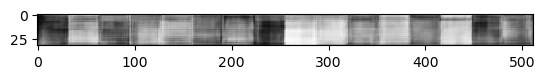

DISC_OUTPUT_FOR_FAKE tensor([[0.6672],
        [0.8695],
        [0.2263],
        [0.0137],
        [0.9441]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.5469],
        [0.9745],
        [0.7322],
        [0.1684],
        [0.4796]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(1.3543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.5439],
        [0.7759],
        [0.2243],
        [0.0128],
        [0.9268]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 0 batch 1
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


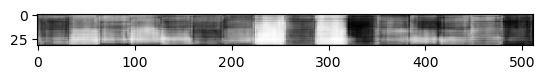

DISC_OUTPUT_FOR_FAKE tensor([[0.0217],
        [0.9153],
        [0.7720],
        [0.9379],
        [0.0930]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.5120],
        [0.5164],
        [0.1187],
        [0.0712],
        [0.4747]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(1.1113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0415],
        [0.9111],
        [0.7613],
        [0.9334],
        [0.1455]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 0 batch 2
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


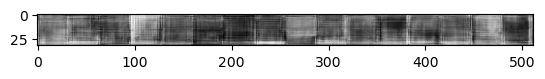

DISC_OUTPUT_FOR_FAKE tensor([[0.9803],
        [0.1966],
        [0.6096],
        [0.2029],
        [0.0752]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.2059],
        [0.9062],
        [0.8858],
        [0.7389],
        [0.0615]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(1.1975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.9781],
        [0.2176],
        [0.6334],
        [0.2270],
        [0.0816]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 0 batch 3
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


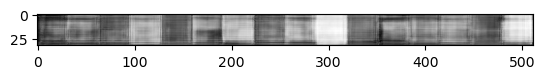

DISC_OUTPUT_FOR_FAKE tensor([[0.1575],
        [0.4392],
        [0.8367],
        [0.0531],
        [0.9132]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.6796],
        [0.3273],
        [0.1027],
        [0.9015],
        [0.4220]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(1.0186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.2236],
        [0.4687],
        [0.8162],
        [0.0799],
        [0.8973]], device='cuda:0', grad_fn=<SigmoidBackward0>)
ADLOSS tensor(1.1278, device='cuda:0') CTC tensor(7.2590, device='cuda:0')
ADLOSS tensor(0.8574, device='cuda:0') CTC tensor(7.4320, device='cuda:0')
Epoch 0:
	Generator and encoder train loss: 8.53300166130066
	Discriminator train loss: 2.177139163017273
	Generator and encoder train accuracy: 327.32666015625
	Discriminator train accuracy: 0.5
	Generator and encoder val loss: 8.338096141815186
	Discriminator val loss: 0.8977365493774414
	Generator and

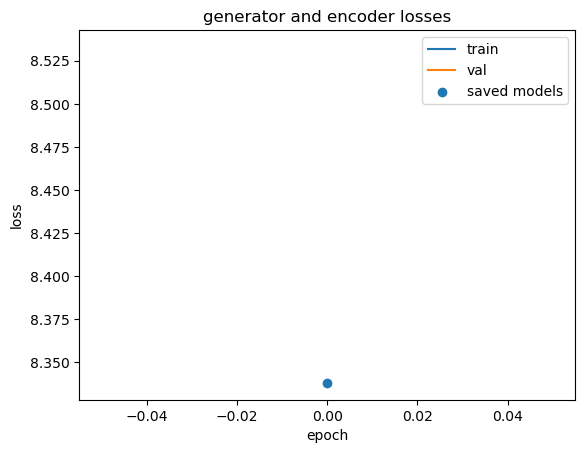

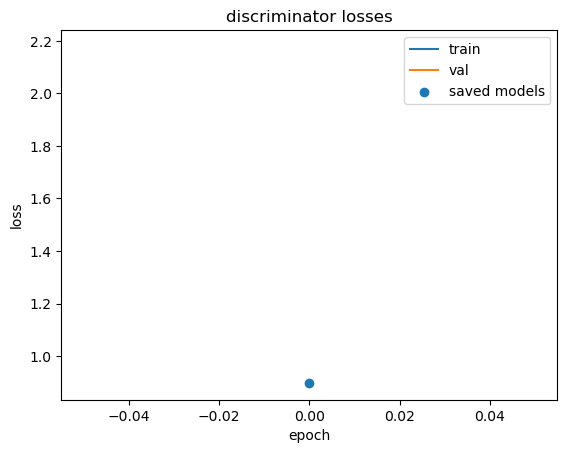

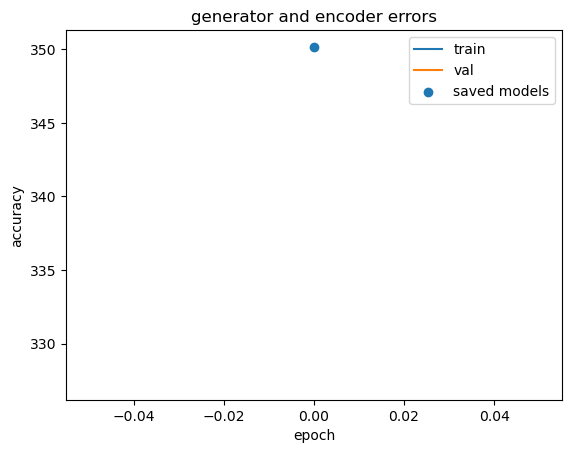

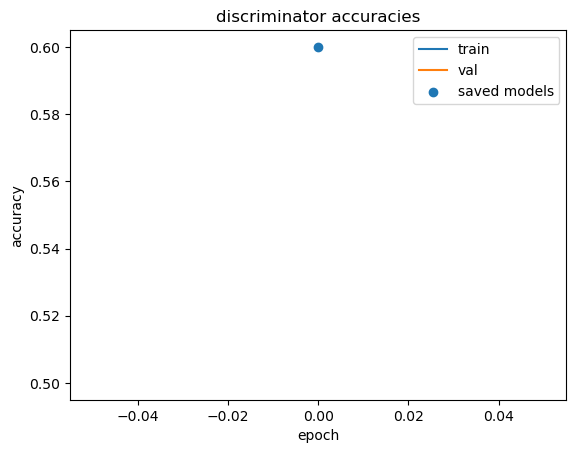

epoch 1 batch 0
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


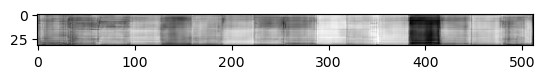

DISC_OUTPUT_FOR_FAKE tensor([[0.1123],
        [0.5279],
        [0.8763],
        [0.3764],
        [0.5648]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.7163],
        [0.0417],
        [0.5780],
        [0.6906],
        [0.7818]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.8530, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.1590],
        [0.5010],
        [0.8503],
        [0.3845],
        [0.5384]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 1 batch 1
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


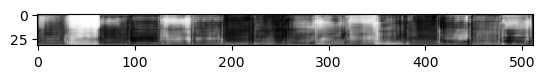

DISC_OUTPUT_FOR_FAKE tensor([[0.0176],
        [0.9187],
        [0.1592],
        [0.9101],
        [0.5538]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.8752],
        [0.5132],
        [0.1669],
        [0.8840],
        [0.1644]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(1.2669, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0225],
        [0.9103],
        [0.1726],
        [0.9037],
        [0.5520]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 1 batch 2
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


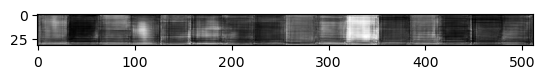

DISC_OUTPUT_FOR_FAKE tensor([[0.4479],
        [0.5730],
        [0.5671],
        [0.6361],
        [0.7803]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.4560],
        [0.1888],
        [0.3624],
        [0.4369],
        [0.8884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(4, device='cuda:0')
tensor(0.5674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.4366],
        [0.5482],
        [0.5376],
        [0.6133],
        [0.7553]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 1 batch 3
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


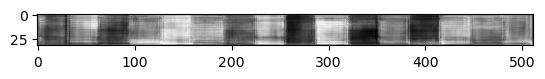

DISC_OUTPUT_FOR_FAKE tensor([[0.4342],
        [0.6557],
        [0.1478],
        [0.7635],
        [0.8973]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.7727],
        [0.9065],
        [0.4357],
        [0.0489],
        [0.3115]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.6349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.4336],
        [0.6456],
        [0.2321],
        [0.7433],
        [0.8858]], device='cuda:0', grad_fn=<SigmoidBackward0>)
ADLOSS tensor(0.8202, device='cuda:0') CTC tensor(7.3107, device='cuda:0')
ADLOSS tensor(1.0311, device='cuda:0') CTC tensor(7.0593, device='cuda:0')
Epoch 1:
	Generator and encoder train loss: 8.079125046730042
	Discriminator train loss: 1.9725103974342346
	Generator and encoder train accuracy: 318.0340576171875
	Discriminator train accuracy: 0.42500001192092896
	Generator and encoder val loss: 8.11066484451294
	Discriminator val loss: 0.905265688896

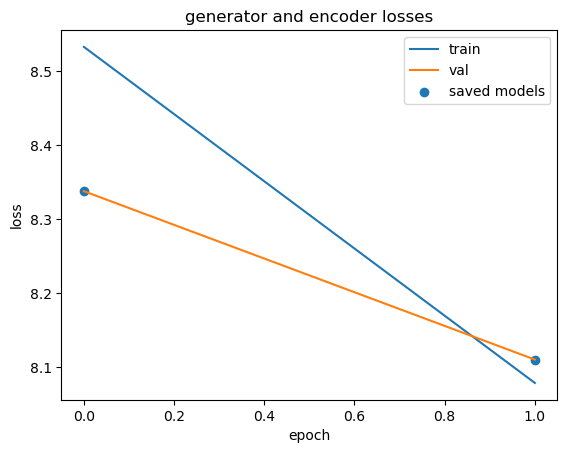

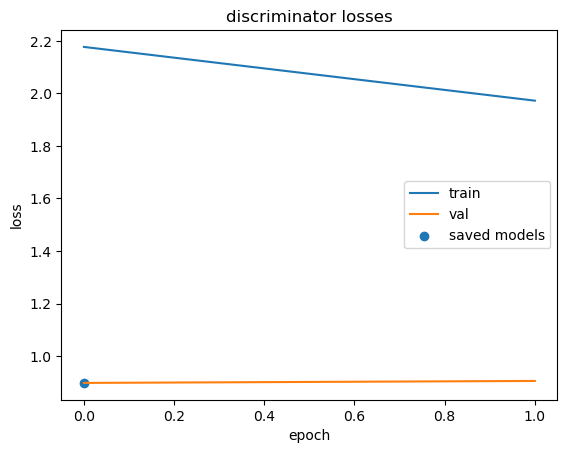

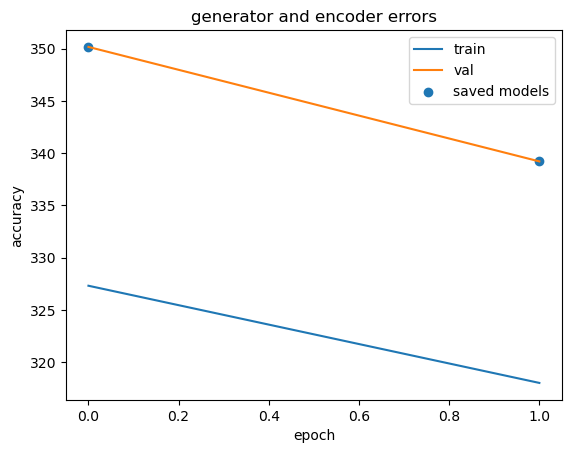

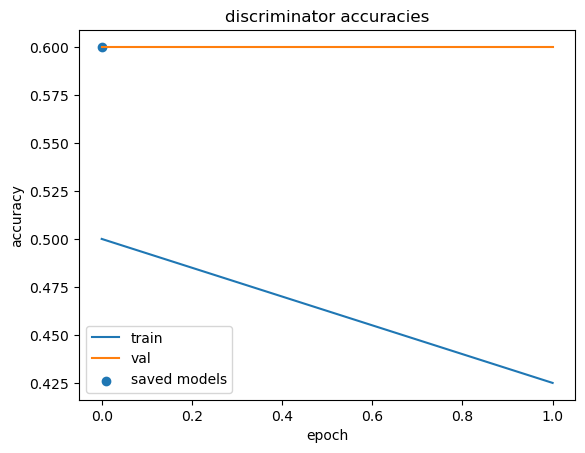

epoch 2 batch 0
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


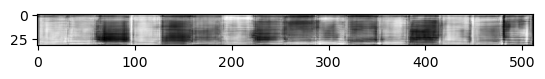

DISC_OUTPUT_FOR_FAKE tensor([[0.0909],
        [0.7862],
        [0.8914],
        [0.5782],
        [0.3866]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.6885],
        [0.3287],
        [0.1786],
        [0.4119],
        [0.9781]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.8164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.1024],
        [0.7443],
        [0.8660],
        [0.5854],
        [0.4404]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 2 batch 1
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


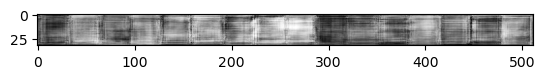

DISC_OUTPUT_FOR_FAKE tensor([[0.0580],
        [0.8669],
        [0.8320],
        [0.5201],
        [0.4806]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.1489],
        [0.1871],
        [0.7978],
        [0.8979],
        [0.6100]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.9275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0645],
        [0.8430],
        [0.7974],
        [0.5025],
        [0.4453]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 2 batch 2
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


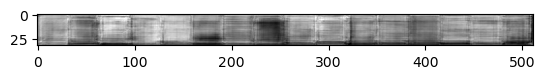

DISC_OUTPUT_FOR_FAKE tensor([[0.7774],
        [0.0633],
        [0.4816],
        [0.7122],
        [0.6691]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.6566],
        [0.0956],
        [0.7090],
        [0.1845],
        [0.9115]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.8506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.7549],
        [0.0895],
        [0.4613],
        [0.7043],
        [0.6488]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 2 batch 3
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


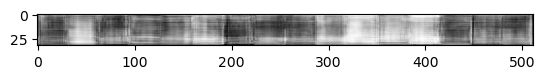

DISC_OUTPUT_FOR_FAKE tensor([[0.7242],
        [0.4084],
        [0.2912],
        [0.4112],
        [0.7409]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.6568],
        [0.0381],
        [0.2728],
        [0.8219],
        [0.8638]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(0.7506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.6212],
        [0.4062],
        [0.3011],
        [0.4172],
        [0.7394]], device='cuda:0', grad_fn=<SigmoidBackward0>)
ADLOSS tensor(1.0478, device='cuda:0') CTC tensor(6.7247, device='cuda:0')
ADLOSS tensor(0.7631, device='cuda:0') CTC tensor(6.7110, device='cuda:0')
Epoch 2:
	Generator and encoder train loss: 7.854182600975037
	Discriminator train loss: 1.8914190530776978
	Generator and encoder train accuracy: 319.94171142578125
	Discriminator train accuracy: 0.5
	Generator and encoder val loss: 7.623327732086182
	Discriminator val loss: 0.8103622198104858
	Generato

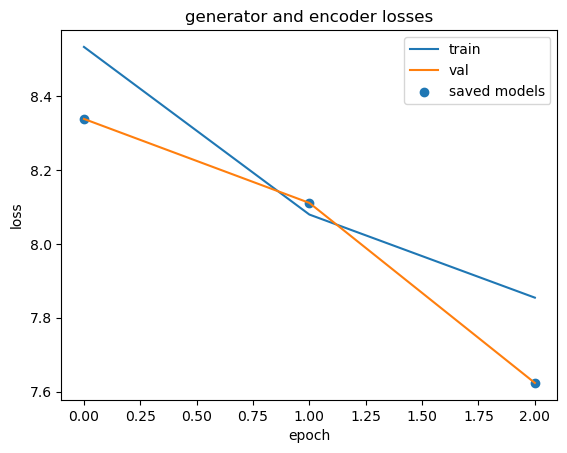

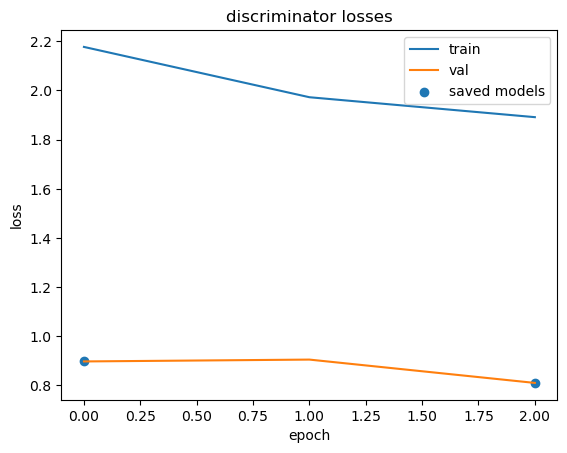

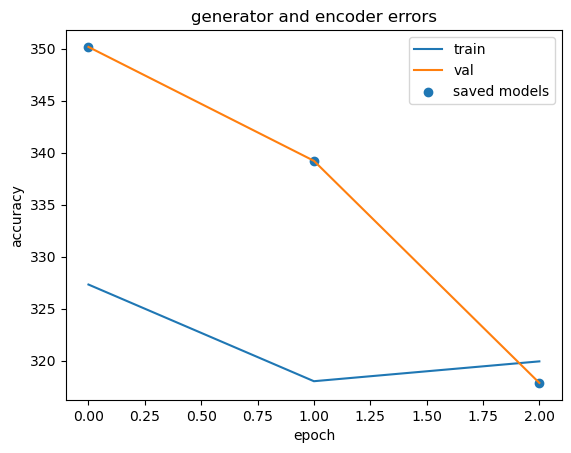

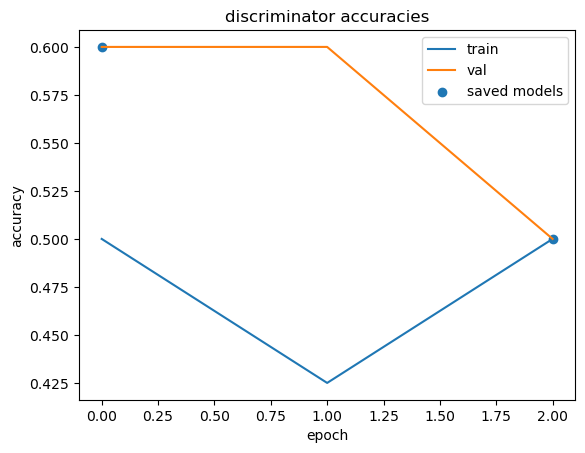

epoch 3 batch 0
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


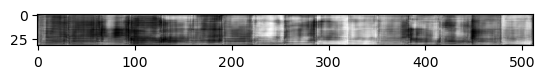

DISC_OUTPUT_FOR_FAKE tensor([[0.3559],
        [0.8737],
        [0.0762],
        [0.4277],
        [0.8287]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.6089],
        [0.5439],
        [0.1400],
        [0.8593],
        [0.2170]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.8452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.3830],
        [0.8760],
        [0.1017],
        [0.5218],
        [0.8283]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 3 batch 1
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


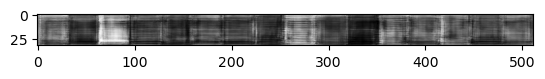

DISC_OUTPUT_FOR_FAKE tensor([[0.4949],
        [0.1843],
        [0.2030],
        [0.6936],
        [0.9440]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.9633],
        [0.2450],
        [0.1785],
        [0.5791],
        [0.8293]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(0.8911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.4591],
        [0.1882],
        [0.2132],
        [0.6813],
        [0.9289]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 3 batch 2
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


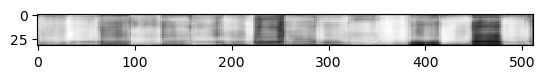

DISC_OUTPUT_FOR_FAKE tensor([[0.6874],
        [0.5550],
        [0.7109],
        [0.2920],
        [0.2834]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.3716],
        [0.7950],
        [0.9402],
        [0.7568],
        [0.1089]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.8450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.5493],
        [0.5017],
        [0.6627],
        [0.2676],
        [0.2963]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 3 batch 3
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


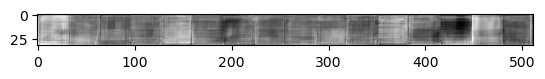

DISC_OUTPUT_FOR_FAKE tensor([[0.8308],
        [0.1471],
        [0.6210],
        [0.0740],
        [0.9318]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.3402],
        [0.5590],
        [0.4190],
        [0.9763],
        [0.2635]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.9293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.8140],
        [0.2550],
        [0.5847],
        [0.0868],
        [0.9189]], device='cuda:0', grad_fn=<SigmoidBackward0>)
ADLOSS tensor(0.9168, device='cuda:0') CTC tensor(4.7980, device='cuda:0')
ADLOSS tensor(1.1495, device='cuda:0') CTC tensor(4.7172, device='cuda:0')
Epoch 3:
	Generator and encoder train loss: 6.998011350631714
	Discriminator train loss: 1.800810158252716
	Generator and encoder train accuracy: 318.4452209472656
	Discriminator train accuracy: 0.5250000357627869
	Generator and encoder val loss: 5.790726900100708
	Discriminator val loss: 1.0194371938705

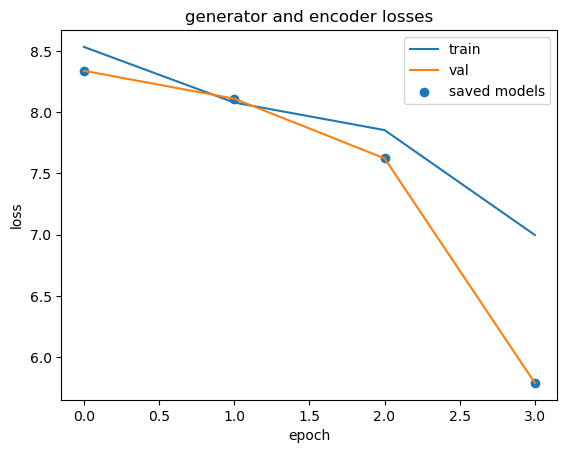

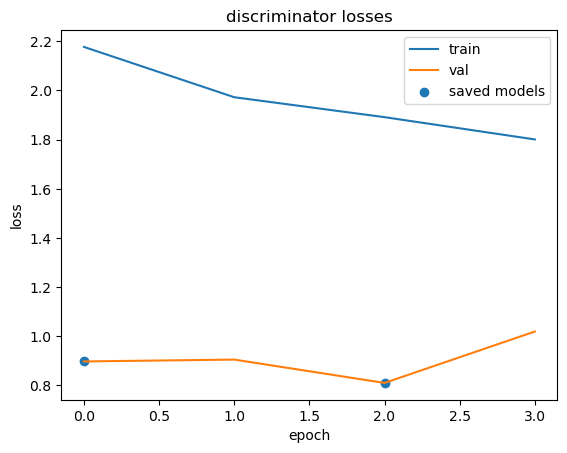

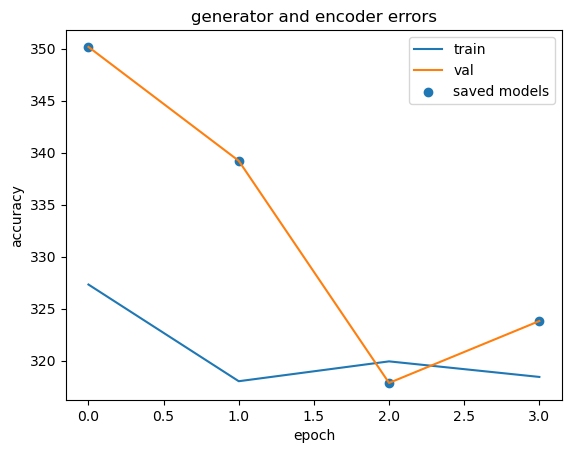

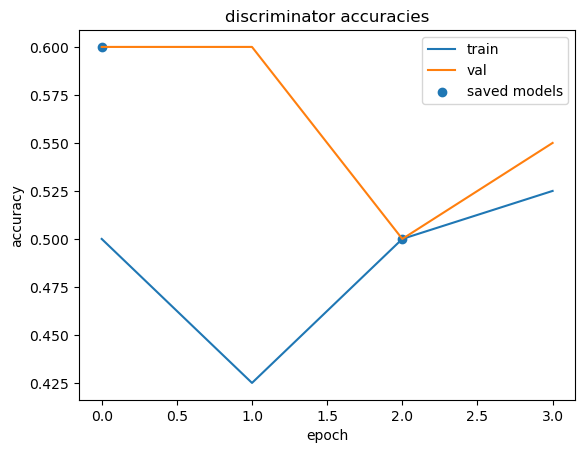

epoch 4 batch 0
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


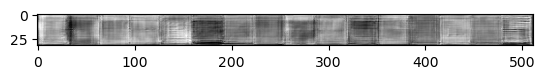

DISC_OUTPUT_FOR_FAKE tensor([[0.6746],
        [0.7144],
        [0.6068],
        [0.1237],
        [0.7717]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.1830],
        [0.6092],
        [0.5615],
        [0.7689],
        [0.8525]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(4, device='cuda:0')
tensor(0.7438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.6160],
        [0.6618],
        [0.5416],
        [0.1534],
        [0.7201]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 4 batch 1
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


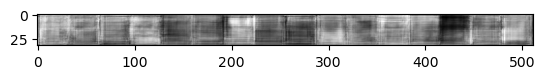

DISC_OUTPUT_FOR_FAKE tensor([[0.5187],
        [0.1547],
        [0.7572],
        [0.4497],
        [0.6158]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.5345],
        [0.8223],
        [0.0972],
        [0.2952],
        [0.6571]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(4, device='cuda:0')
tensor(0.7097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.5254],
        [0.2345],
        [0.7567],
        [0.5048],
        [0.6144]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 4 batch 2
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


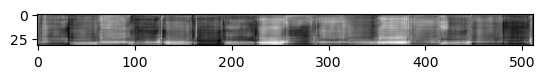

DISC_OUTPUT_FOR_FAKE tensor([[0.8181],
        [0.2225],
        [0.4270],
        [0.4765],
        [0.4275]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.1273],
        [0.8875],
        [0.2024],
        [0.8837],
        [0.8896]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(1, device='cuda:0')
tensor(0.8178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.7947],
        [0.2632],
        [0.3967],
        [0.4610],
        [0.4359]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 4 batch 3
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


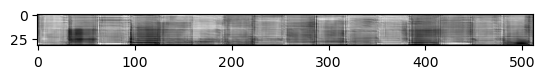

DISC_OUTPUT_FOR_FAKE tensor([[0.8982],
        [0.5432],
        [0.6447],
        [0.2546],
        [0.1902]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.4144],
        [0.3604],
        [0.9571],
        [0.5663],
        [0.2974]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.7598, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.8796],
        [0.5622],
        [0.6258],
        [0.2763],
        [0.2639]], device='cuda:0', grad_fn=<SigmoidBackward0>)
ADLOSS tensor(1.2279, device='cuda:0') CTC tensor(2.5028, device='cuda:0')
ADLOSS tensor(0.7158, device='cuda:0') CTC tensor(2.5179, device='cuda:0')
Epoch 4:
	Generator and encoder train loss: 4.530371606349945
	Discriminator train loss: 1.644574761390686
	Generator and encoder train accuracy: 327.4779052734375
	Discriminator train accuracy: 0.5250000357627869
	Generator and encoder val loss: 3.4821794033050537
	Discriminator val loss: 0.815818250179

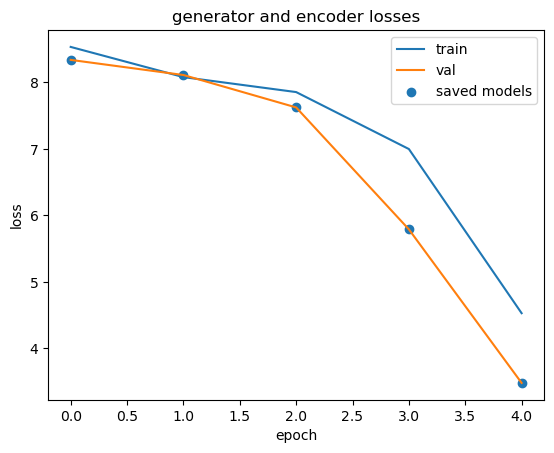

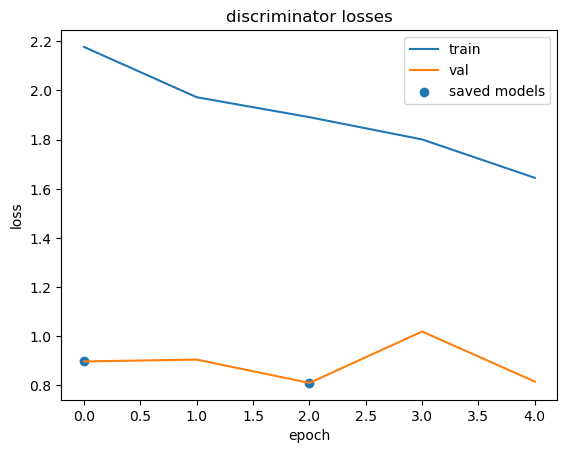

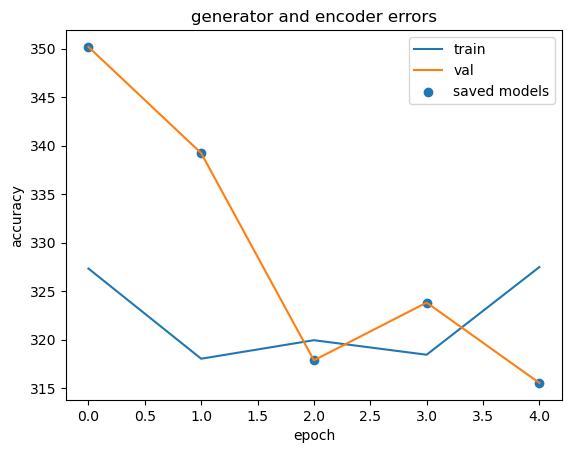

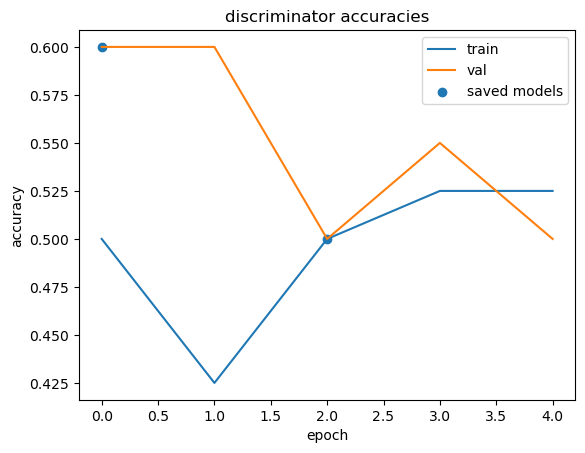

epoch 5 batch 0
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


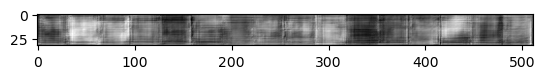

DISC_OUTPUT_FOR_FAKE tensor([[0.5911],
        [0.3612],
        [0.8373],
        [0.6402],
        [0.3022]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.2769],
        [0.3726],
        [0.4034],
        [0.7108],
        [0.9604]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.6903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.5707],
        [0.3501],
        [0.8200],
        [0.6200],
        [0.3149]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 5 batch 1
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


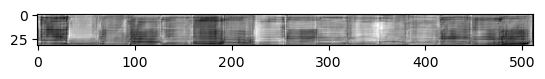

DISC_OUTPUT_FOR_FAKE tensor([[0.2553],
        [0.0908],
        [0.6808],
        [0.2250],
        [0.9914]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.6784],
        [0.4162],
        [0.5511],
        [0.9170],
        [0.8470]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(1.1857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.2443],
        [0.0813],
        [0.6562],
        [0.2075],
        [0.9804]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 5 batch 2
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


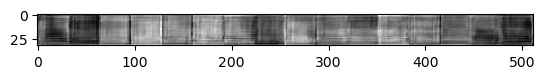

DISC_OUTPUT_FOR_FAKE tensor([[0.8233],
        [0.0593],
        [0.9384],
        [0.2504],
        [0.8562]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.9668],
        [0.2413],
        [0.5682],
        [0.8499],
        [0.2522]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.9657, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.7741],
        [0.0581],
        [0.9135],
        [0.2402],
        [0.8204]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 5 batch 3
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


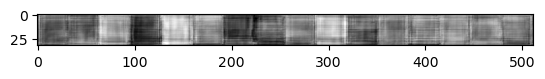

DISC_OUTPUT_FOR_FAKE tensor([[0.3094],
        [0.1019],
        [0.1327],
        [0.3839],
        [0.6313]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.6849],
        [0.8940],
        [0.6696],
        [0.2340],
        [0.2258]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(1, device='cuda:0')
tensor(1.1346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.3493],
        [0.1837],
        [0.1792],
        [0.4298],
        [0.6738]], device='cuda:0', grad_fn=<SigmoidBackward0>)
ADLOSS tensor(0.9270, device='cuda:0') CTC tensor(1.9429, device='cuda:0')
ADLOSS tensor(0.6053, device='cuda:0') CTC tensor(2.0167, device='cuda:0')
Epoch 5:
	Generator and encoder train loss: 3.2480133175849915
	Discriminator train loss: 1.6591202914714813
	Generator and encoder train accuracy: 324.53436279296875
	Discriminator train accuracy: 0.574999988079071
	Generator and encoder val loss: 2.745951771736145
	Discriminator val loss: 0.62911701202

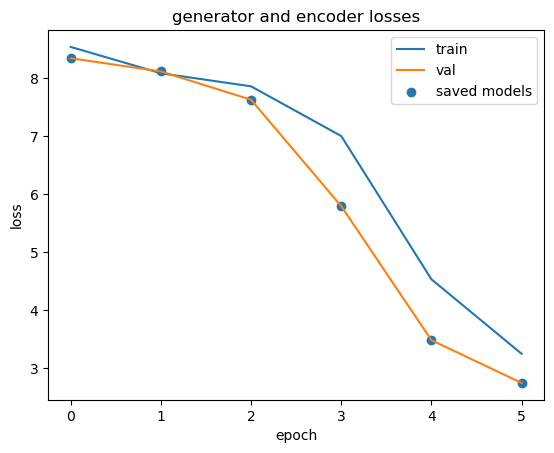

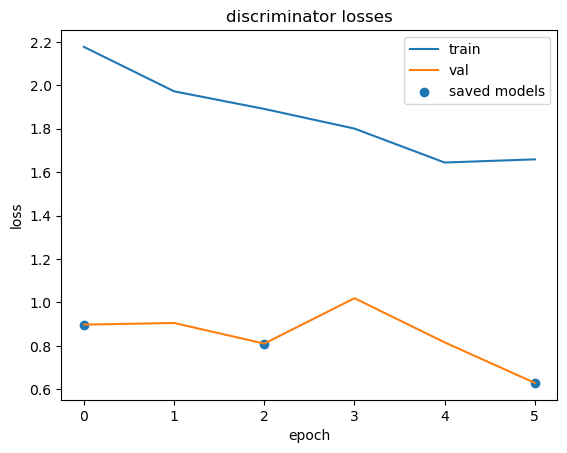

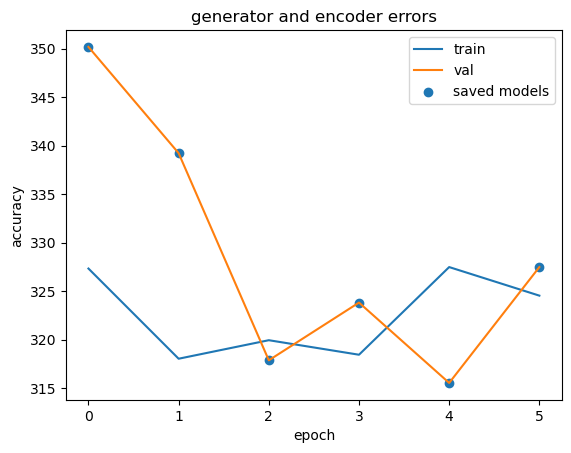

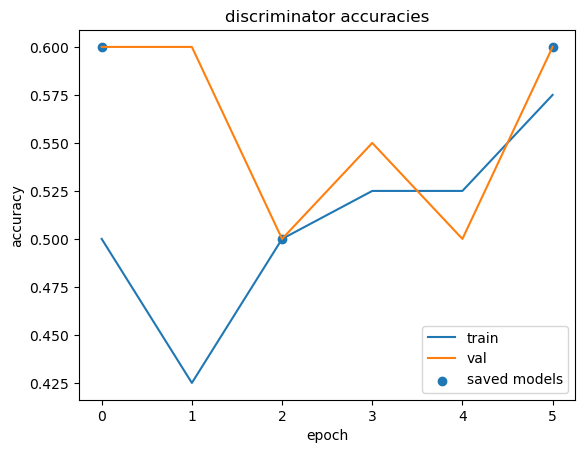

epoch 6 batch 0
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


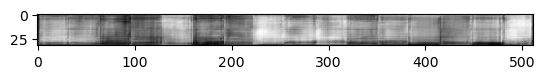

DISC_OUTPUT_FOR_FAKE tensor([[0.5940],
        [0.3188],
        [0.3221],
        [0.1925],
        [0.4232]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.5293],
        [0.5987],
        [0.5275],
        [0.8986],
        [0.8286]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(0, device='cuda:0')
tensor(1.1498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.4695],
        [0.2990],
        [0.3161],
        [0.1857],
        [0.3724]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 6 batch 1
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


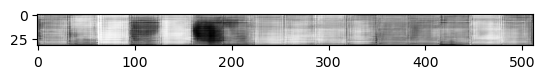

DISC_OUTPUT_FOR_FAKE tensor([[0.8425],
        [0.8538],
        [0.1489],
        [0.0936],
        [0.3613]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.9081],
        [0.9479],
        [0.2436],
        [0.6827],
        [0.1949]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(1.1416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.8059],
        [0.8272],
        [0.1496],
        [0.0966],
        [0.3391]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 6 batch 2
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


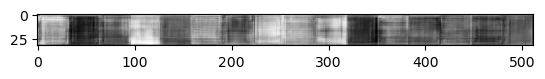

DISC_OUTPUT_FOR_FAKE tensor([[0.6850],
        [0.8030],
        [0.7193],
        [0.1761],
        [0.2176]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.2919],
        [0.3521],
        [0.8787],
        [0.6718],
        [0.6136]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(3, device='cuda:0')
tensor(0.8952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.6474],
        [0.6929],
        [0.7059],
        [0.1661],
        [0.2150]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 6 batch 3
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


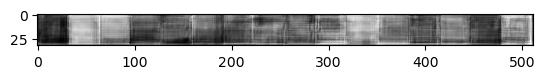

DISC_OUTPUT_FOR_FAKE tensor([[0.7553],
        [0.7255],
        [0.3654],
        [0.4111],
        [0.4042]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.4254],
        [0.8360],
        [0.8836],
        [0.6637],
        [0.2126]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(0.7841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.7065],
        [0.6571],
        [0.3232],
        [0.3639],
        [0.3619]], device='cuda:0', grad_fn=<SigmoidBackward0>)
ADLOSS tensor(1.0378, device='cuda:0') CTC tensor(1.5986, device='cuda:0')
ADLOSS tensor(0.9961, device='cuda:0') CTC tensor(2.3658, device='cuda:0')
Epoch 6:
	Generator and encoder train loss: 2.998895823955536
	Discriminator train loss: 1.391505628824234
	Generator and encoder train accuracy: 328.1108093261719
	Discriminator train accuracy: 0.6499999761581421
	Generator and encoder val loss: 2.9991122484207153
	Discriminator val loss: 0.549145996570

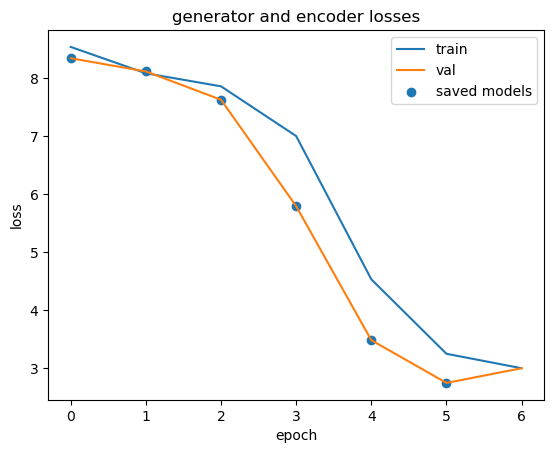

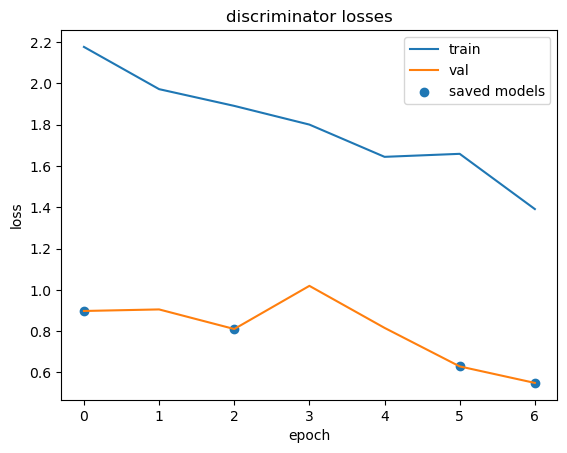

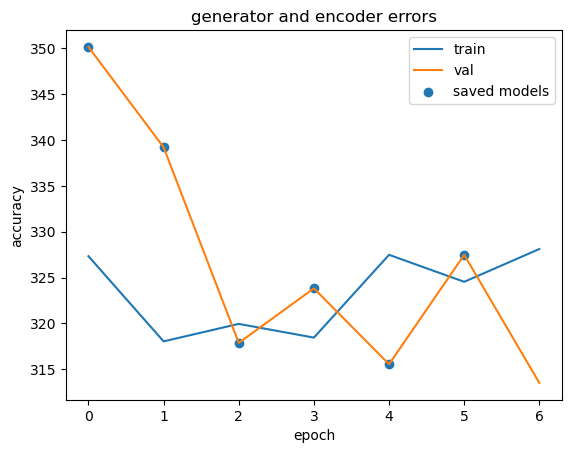

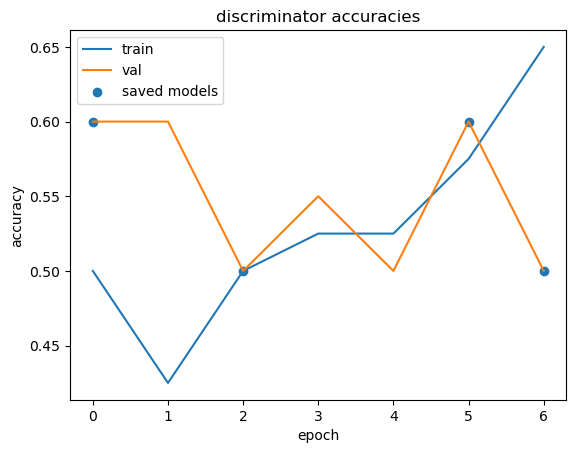

epoch 7 batch 0
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


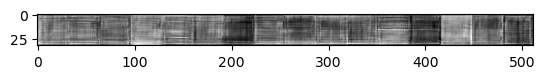

DISC_OUTPUT_FOR_FAKE tensor([[0.8453],
        [0.1013],
        [0.0724],
        [0.5725],
        [0.6736]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.8007],
        [0.4800],
        [0.6929],
        [0.8987],
        [0.3353]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(1.2861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.8050],
        [0.0898],
        [0.0785],
        [0.4439],
        [0.6209]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 7 batch 1
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


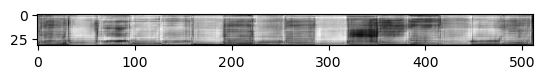

DISC_OUTPUT_FOR_FAKE tensor([[0.5786],
        [0.4135],
        [0.0402],
        [0.4345],
        [0.3621]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.3518],
        [0.6742],
        [0.7516],
        [0.3551],
        [0.3274]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(1.1006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.6274],
        [0.4648],
        [0.0608],
        [0.5062],
        [0.4422]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 7 batch 2
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


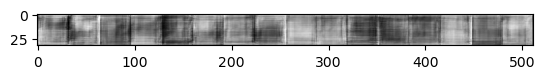

DISC_OUTPUT_FOR_FAKE tensor([[0.3695],
        [0.4639],
        [0.6741],
        [0.4522],
        [0.5414]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.7061],
        [0.1815],
        [0.7879],
        [0.6917],
        [0.1821]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(0.6940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.3826],
        [0.4810],
        [0.6762],
        [0.4666],
        [0.5371]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 7 batch 3
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


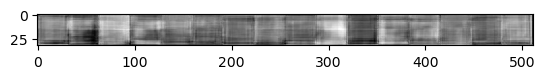

DISC_OUTPUT_FOR_FAKE tensor([[0.2062],
        [0.6040],
        [0.1888],
        [0.4481],
        [0.8849]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.9525],
        [0.7940],
        [0.4503],
        [0.3573],
        [0.4424]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(0.9436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.2060],
        [0.5488],
        [0.1835],
        [0.4982],
        [0.8565]], device='cuda:0', grad_fn=<SigmoidBackward0>)
ADLOSS tensor(0.8014, device='cuda:0') CTC tensor(1.9021, device='cuda:0')
ADLOSS tensor(1.4403, device='cuda:0') CTC tensor(2.0492, device='cuda:0')
Epoch 7:
	Generator and encoder train loss: 3.0203177332878113
	Discriminator train loss: 1.4002690613269806
	Generator and encoder train accuracy: 322.3818664550781
	Discriminator train accuracy: 0.550000011920929
	Generator and encoder val loss: 3.0964725017547607
	Discriminator val loss: 0.74163854122

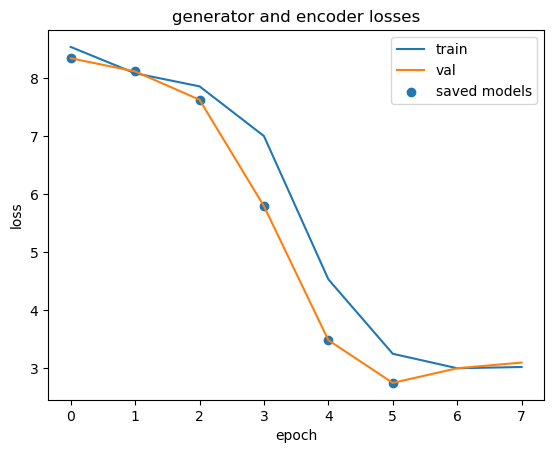

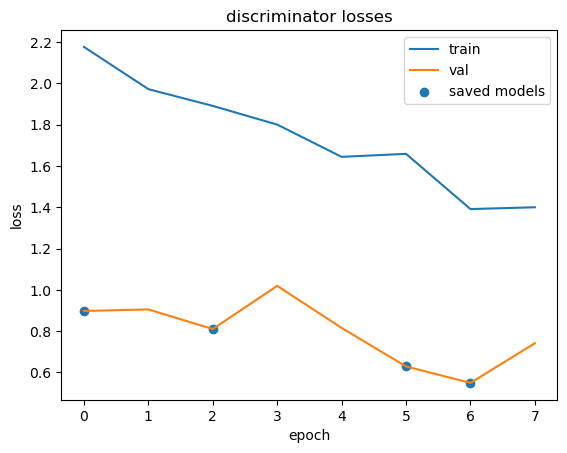

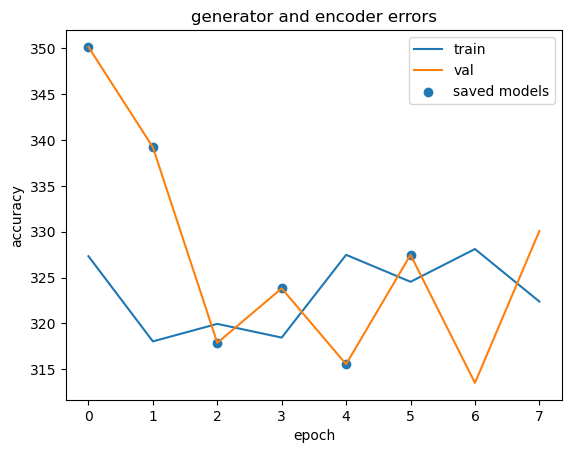

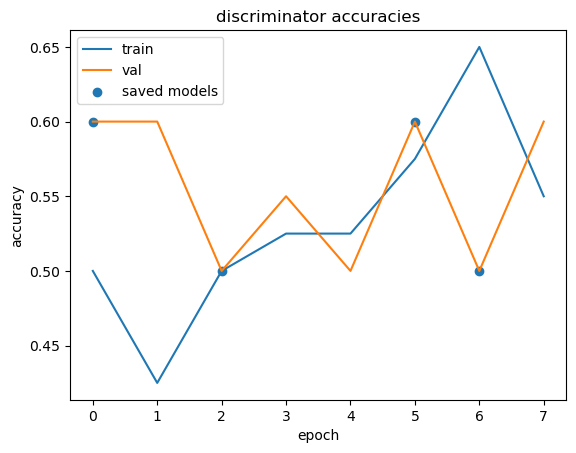

epoch 8 batch 0
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


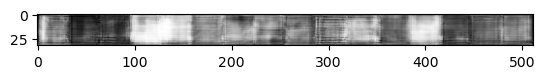

DISC_OUTPUT_FOR_FAKE tensor([[0.3068],
        [0.5561],
        [0.3148],
        [0.1189],
        [0.9389]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.6961],
        [0.1953],
        [0.8716],
        [0.4770],
        [0.6465]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(0.9326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.3930],
        [0.5247],
        [0.3385],
        [0.1451],
        [0.9300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 8 batch 1
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


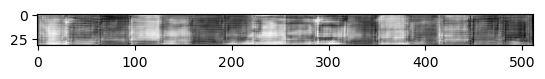

DISC_OUTPUT_FOR_FAKE tensor([[0.6281],
        [0.3163],
        [0.5910],
        [0.6099],
        [0.4190]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.8196],
        [0.9055],
        [0.3686],
        [0.6116],
        [0.5829]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(0.8827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.5312],
        [0.2530],
        [0.5156],
        [0.4905],
        [0.3510]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 8 batch 2
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


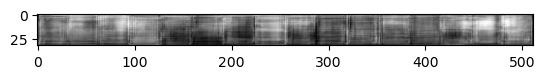

DISC_OUTPUT_FOR_FAKE tensor([[0.1250],
        [0.5642],
        [0.6756],
        [0.2518],
        [0.4670]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.4316],
        [0.5413],
        [0.9287],
        [0.2011],
        [0.5031]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(2, device='cuda:0')
tensor(0.9476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.1563],
        [0.5615],
        [0.6962],
        [0.2879],
        [0.4902]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 8 batch 3
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


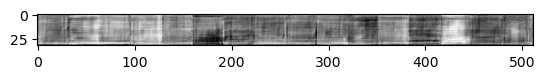

DISC_OUTPUT_FOR_FAKE tensor([[0.5523],
        [0.4860],
        [0.6574],
        [0.5630],
        [0.2725]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.6856],
        [0.7114],
        [0.8077],
        [0.5799],
        [0.5819]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(1, device='cuda:0')
tensor(0.9030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.4710],
        [0.4085],
        [0.5619],
        [0.4517],
        [0.2204]], device='cuda:0', grad_fn=<SigmoidBackward0>)
ADLOSS tensor(1.1348, device='cuda:0') CTC tensor(1.4679, device='cuda:0')
ADLOSS tensor(1.1479, device='cuda:0') CTC tensor(2.3661, device='cuda:0')
Epoch 8:
	Generator and encoder train loss: 2.896702468395233
	Discriminator train loss: 1.3263414800167084
	Generator and encoder train accuracy: 321.593017578125
	Discriminator train accuracy: 0.625
	Generator and encoder val loss: 3.058331608772278
	Discriminator val loss: 0.5936563014984131
	Generato

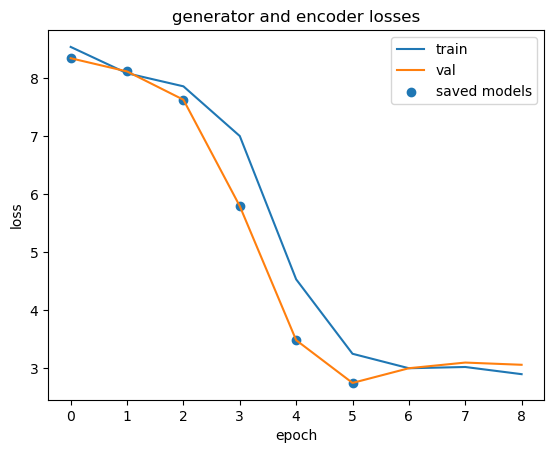

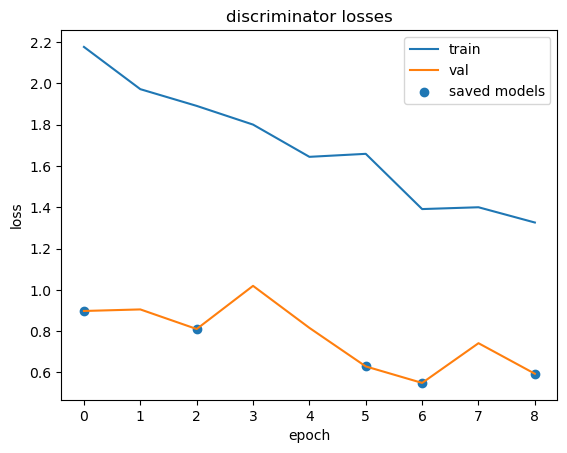

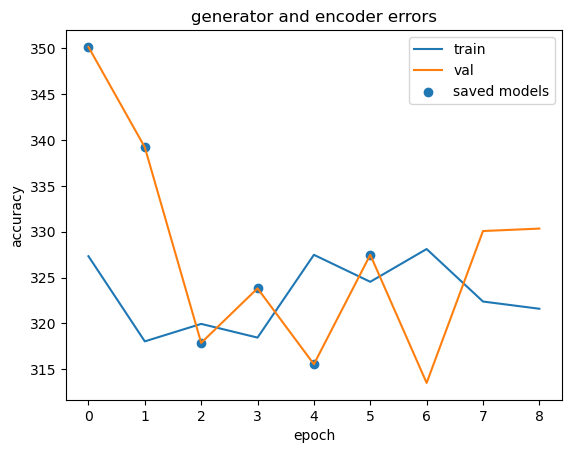

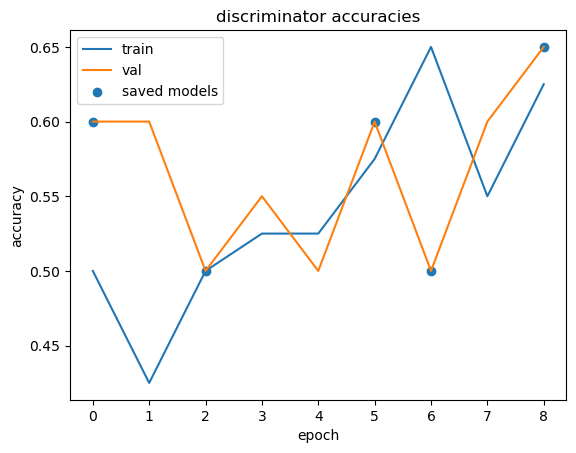

epoch 9 batch 0
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


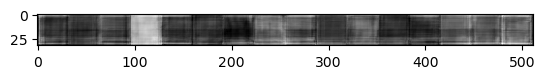

DISC_OUTPUT_FOR_FAKE tensor([[0.4675],
        [0.2945],
        [0.0624],
        [0.9108],
        [0.0725]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.4891],
        [0.5014],
        [0.7260],
        [0.7265],
        [0.5342]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(1, device='cuda:0')
tensor(1.4137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.4916],
        [0.3000],
        [0.0688],
        [0.8536],
        [0.0945]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 9 batch 1
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


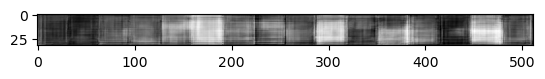

DISC_OUTPUT_FOR_FAKE tensor([[0.3920],
        [0.2105],
        [0.3739],
        [0.3704],
        [0.2334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.7632],
        [0.2521],
        [0.5714],
        [0.8836],
        [0.8413]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(0, device='cuda:0')
tensor(1.1469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.3936],
        [0.2230],
        [0.3796],
        [0.3805],
        [0.2455]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 9 batch 2
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


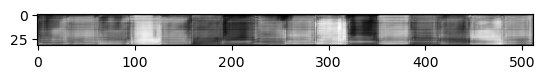

DISC_OUTPUT_FOR_FAKE tensor([[0.3120],
        [0.3279],
        [0.6337],
        [0.2704],
        [0.2953]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.8668],
        [0.1482],
        [0.8591],
        [0.7798],
        [0.3445]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(1, device='cuda:0')
tensor(0.9466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.3604],
        [0.4043],
        [0.6334],
        [0.2959],
        [0.3156]], device='cuda:0', grad_fn=<SigmoidBackward0>)
epoch 9 batch 3
real_image_batch.shape torch.Size([5, 1, 32, 512])
input_text_batch.shape torch.Size([5, 82])
torch.Size([5, 384]) torch.Size([5, 512])


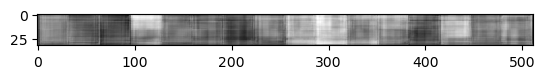

DISC_OUTPUT_FOR_FAKE tensor([[0.2697],
        [0.3086],
        [0.3357],
        [0.4586],
        [0.2899]], device='cuda:0', grad_fn=<SigmoidBackward0>)
D_OUTPUT_FOR_REAL tensor([[0.1842],
        [0.2877],
        [0.7422],
        [0.5364],
        [0.8413]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor(1, device='cuda:0')
tensor(0.9364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.3305],
        [0.3864],
        [0.3916],
        [0.5203],
        [0.3483]], device='cuda:0', grad_fn=<SigmoidBackward0>)
ADLOSS tensor(0.6973, device='cuda:0') CTC tensor(1.9951, device='cuda:0')
ADLOSS tensor(0.8117, device='cuda:0') CTC tensor(1.6680, device='cuda:0')
Epoch 9:
	Generator and encoder train loss: 3.0081557035446167
	Discriminator train loss: 1.1457955092191696
	Generator and encoder train accuracy: 329.50433349609375
	Discriminator train accuracy: 0.800000011920929
	Generator and encoder val loss: 2.586019992828369
	Discriminator val loss: 0.66500192880

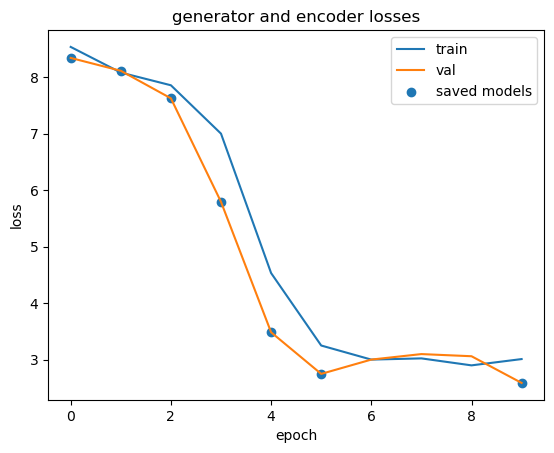

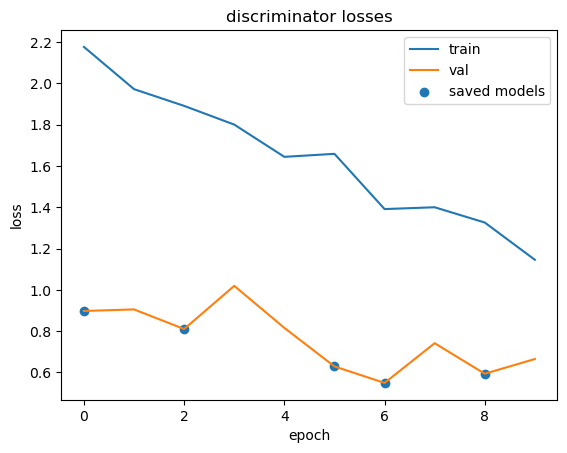

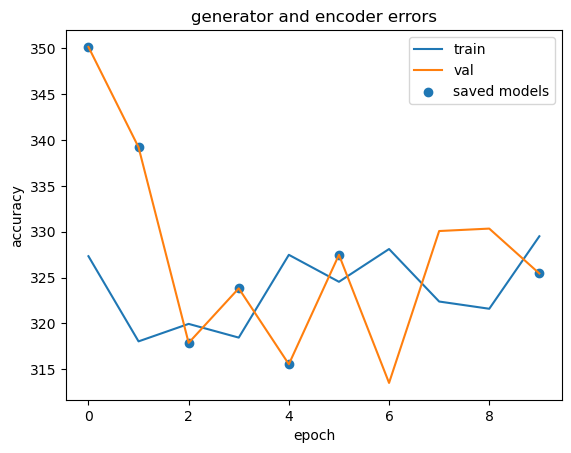

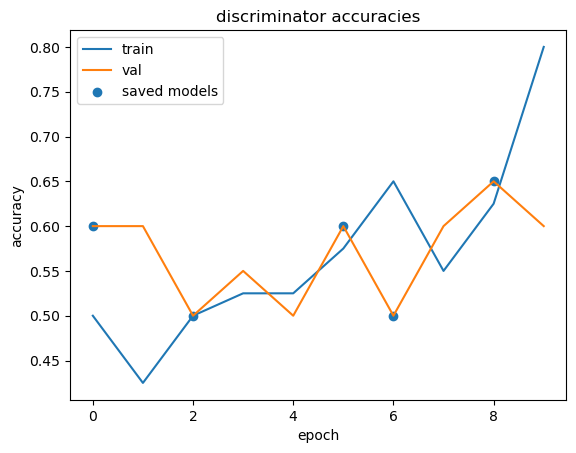

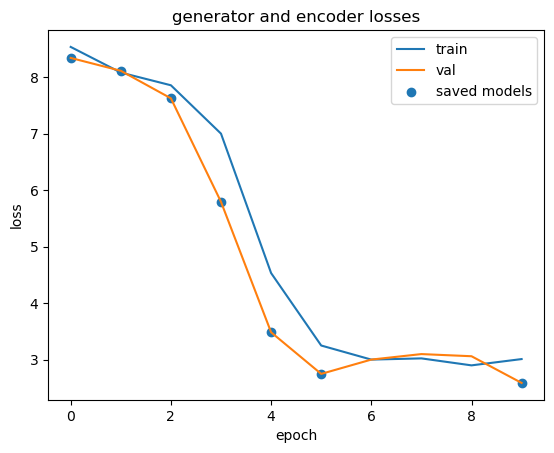

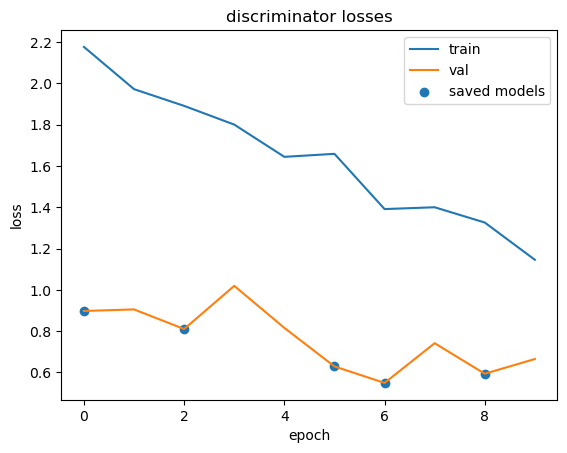

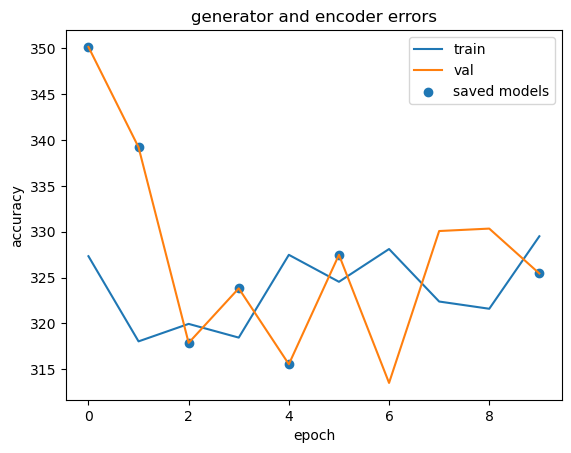

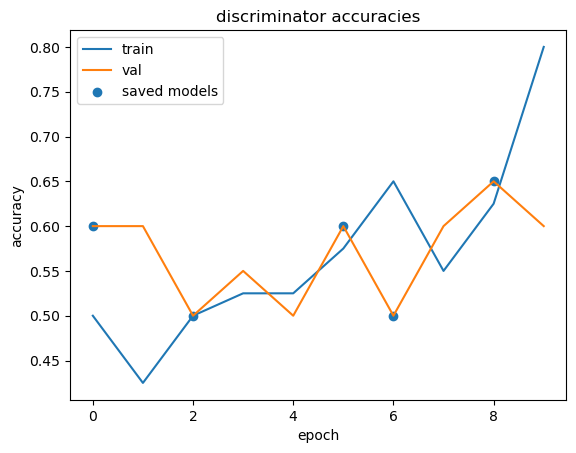

In [32]:
generator = Generator()
discriminator = Discriminator()
encoder = Encoder()
recognizer = Recognizer()
# generator = load_model(generator, "main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)_generator_epoch9.pt")
# generator, encoder, discriminator = load_models_of_same_batch(generator, encoder, discriminator, filename_prefix="main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)", epoch_number=9)

train_gan(encoder_lr=0.0001, generator_lr=1e-6, discriminator_lr=1e-6, recognizer_lr=0.0001,
          num_epochs=10, batch_size=5, 
          encoder=encoder, generator=generator ,discriminator=discriminator,
          train_real_image_dataset=line_image_dataset_train, val_real_image_dataset=line_image_dataset_val, 
          train_input_text_dataset=line_transcription_dataset_train, val_input_text_dataset=line_transcription_dataset_val, 
          recognizer=recognizer, num_generator_updates_per_discriminator_update=1)